# Linear regression/ Least square fits

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cmocean
import scipy.signal as sig
import scipy.io as sio
import scipy.interpolate as sciint
import seaborn as sns
import pylab as pl
import xarray as xr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import ffmpeg
from math import radians, cos, sin, asin, sqrt
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Getting the values 

In [2]:
def get_Brink(file_fig):#,file_h): #, file_ratio):
    # Brink mode
    file = sio.loadmat(file_fig)
    z, xpl, xxx, zzz, xgr, zgr = file['z'][0,:], file['xpl'][0,:], file['xxx'][0,:], file['zzz'][0,:], file['xgr'], file['zgr']
    k, omega = file['wavenumber'][0][0], file['frequency'][0][0]

    # (u is cross-shore and v is alongshore in Brink.)
    p0, u0, v0, w0, r0 = file['p'], file['u'],file['v'], file['wvel'], file['rho']

    #file_rfw = sio.loadmat(file_ratio)
    #R = file_rfw['ratio_for_wave'][0][0]
    #print('ratio for wave', R)
    #print('k (rad/cm) ', k)
    
    #print('lambda (km) ', ((2*np.pi)/(k*100))*1E-3)
    #print('omega (rad/s) ', omega)
    #print('period (days)', ((2*np.pi)/omega)/(3600*24))
    #print('c (m/s)', (omega/(k*100)))
    scale=0.2
    w = w0.transpose() * 0.01 * scale # cms-1 to ms-1 and normalization (?)
    u = u0.transpose() * 0.01 * scale # cms-1 to ms-1 and normalization 
    v = v0.transpose() * 0.01 * scale # cms-1 to ms-1 and normalization 
    r = r0.transpose() * 1.0 * scale # mg/cm³ to kg/m³ and normalization
    p = p0.transpose() * 0.1 * scale # dyn/cm² to 0.1 Pa (or kg m-1 s-2) and normalization
    
   # hfile=sio.loadmat(file_h)
    #h=hfile['h']
    
    #nn=np.size(h)+2
    #mm=np.size(h)+2
    #xgr = np.zeros((nn-2,mm-2))
    #zgr =  np.zeros((nn-2,mm-2))
    #xmax=max(xpl)
    #xmax = xmax*1.0e05
    #dt = 1/(mm-3)
    #dx = xmax/(nn-3)
    #for n in np.arange(0,nn-2,1):
     #   xtemp = dx*n
      #  xgr[n,:] = (xtemp*np.ones(mm-2))/1e5
       # zgr[n,:] = h[0,n]*(-1+dt*np.arange(0,mm-2,1))/100
    
    #z[0:-1]=-np.log10(-z[0:-1])
    #zzz=-np.log10(-zzz)
    
    return(u,v,w,r,p,z,k,omega,xpl, xxx, zzz,zgr.transpose(),xgr.transpose())

def loadNetCDFs(varname):
    dsw=[]
    dsn=[]
    for i in np.arange(0,8,1):
        
        if varname=='DYNVARS':
            pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'noSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
            pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        else:
            pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01b_noSVB_febTS/'+ str(varname)+'noSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
            pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01b_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        
        dswin  = xr.open_dataset(pathw)
        dsnin = xr.open_dataset(pathn)
        
        dsw.append(dswin)
        dsn.append(dsnin)
        
    return dsw, dsn

# Plot

In [3]:
def LINREGplot(fig,VALMITp,VALFITp,varbrink1,varbrink2,varbrink3,varbrink4,dsw,ind,lat,grid_Z,grid_X,
               dist,Zin,TIME,BETAp,FITp,t,rmse):
    
    xlab='Crosshore distance [km]'
    ylab='Depth [m]'
    fig = plt.figure(tight_layout=True)
    gs = GridSpec(nrows=4, ncols=2, height_ratios=[1.5,1,1,1])
    
    depths=np.arange(75,-1,-1)
    vmin=-np.nanmax(abs(VALMITp[t,:,:]))
    vmax=np.nanmax(abs(VALMITp[t,:,:]))

    levels=np.linspace(vmin,vmax,15)

    vminb=-np.nanmax(abs(varbrink3[:,:]))
    vmaxb=np.nanmax(abs(varbrink3[:,:]))

    levelsb=np.linspace(vminb,vmaxb,15)
    
    
    Z=Zin[Zin>=-1000]
    
    hFacC = dsw[0].hFacC
    hfac = np.ma.masked_values(hFacC, 0)
    mask = np.ma.getmask(hfac)
    maski=mask[depths,ind,:]
    masky=maski[Zin>=-1000,:]
    coast=np.where(mask[0,ind,:]==False)

    LON = dsw[0].XC[coast]-360

    distance=cos((lat*np.pi)/180)*111*-1*(LON-LON[-1])
    
    if lat>32:
        indlonpre=np.where(distance<=80)
    else:
        indlonpre=np.where(distance<=99)
        
    indlon=np.flip(indlonpre[0])


    ax0 = fig.add_subplot(gs[1, 0])
    ax0.set_facecolor('tan')
    cax1=ax0.contourf(grid_X,grid_Z,VALFITp[t,:,:],cmap=cmocean.cm.delta,levels=levels)
    ax0.contour(grid_X,grid_Z,VALFITp[t,:,:], levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax0.set(xlabel=xlab, ylabel=ylab)
    ax0.set_title('Linear regression fit')
   
    
    ax1 = fig.add_subplot(gs[1, 1])
    ax1.set_facecolor('tan')
    ax1.contourf(grid_X,grid_Z,VALMITp[t,:,:],cmap=cmocean.cm.delta,levels=levels)
    ax1.contour(grid_X,grid_Z,VALMITp[t,:,:], levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax1.set(xlabel=xlab, ylabel=ylab)
    ax1.set_title('MITgcm')
    

    ax2 = fig.add_subplot(gs[2, 0])
    ax2.set_facecolor('tan')
    ax2.contourf(grid_X,grid_Z,varbrink1 ,cmap=cmocean.cm.delta,levels=levelsb)
    ax2.contour(grid_X,grid_Z,varbrink1 , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax2.set(xlabel=xlab, ylabel=ylab)
    ax2.set_title('Brink mode 1')
    

    ax3 = fig.add_subplot(gs[2, 1])
    ax3.set_facecolor('tan')
    ax3.contourf(grid_X,grid_Z,varbrink2 ,cmap=cmocean.cm.delta,levels=levelsb)
    ax3.contour(grid_X,grid_Z,varbrink2 , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax3.set(xlabel=xlab, ylabel=ylab)
    ax3.set_title('Brink mode 2')
   
    ax4 = fig.add_subplot(gs[3, 0])
    ax4.set_facecolor('tan')
    ax4.contourf(grid_X,grid_Z,varbrink3 ,cmap=cmocean.cm.delta,levels=levelsb)
    ax4.contour(grid_X,grid_Z,varbrink3 , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax4.set(xlabel=xlab, ylabel=ylab)
    ax4.set_title('Brink mode 3')
    

    ax5 = fig.add_subplot(gs[3, 1])
    ax5.set_facecolor('tan')
    cax2=ax5.contourf(grid_X,grid_Z,varbrink4 ,cmap=cmocean.cm.delta,levels=levelsb)
    ax5.contour(grid_X,grid_Z,varbrink4 , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax5.set(xlabel=xlab, ylabel=ylab)
    
    ax5.set_title('Brink mode 4')
    
    
    vminr=-np.nanmax(abs(VALMITp[t,:,:]-VALFITp[t,:,:] ))
    vmaxr=np.nanmax(abs(VALMITp[t,:,:]-VALFITp[t,:,:] ))

    levelsr=np.linspace(vminr,vmaxr,15)
    
    ax6 = fig.add_subplot(gs[0, :])
    ax6.set_facecolor('tan')
    cax3=ax6.contourf(grid_X,grid_Z,VALMITp[t,:,:]-VALFITp[t,:,:] ,cmap=cmocean.cm.delta,levels=levelsr)
    ax6.contour(grid_X,grid_Z,VALMITp[t,:,:]-VALFITp[t,:,:] , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax6.set(xlabel=xlab, ylabel=ylab)
    ax6.set_title('Residuals')    
    

    cbar_ax = fig.add_axes([1, 0.48, 0.03, 0.14])
    fig.colorbar(cax1, cax=cbar_ax)
    cbar_ax.set_ylabel('Pressure')
    cbar_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    
    cbar_ax2 = fig.add_axes([1, 0.08, 0.03, 0.3])
    fig.colorbar(cax2, cax=cbar_ax2)
    cbar_ax2.set_ylabel('Pressure')
    cbar_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    
    cbar_ax3 = fig.add_axes([1, 0.72, 0.03, 0.14])
    fig.colorbar(cax3, cax=cbar_ax3)
    cbar_ax3.set_ylabel('Residuals')
    cbar_ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    
    fig.suptitle(f'Regression line: Y = {BETAp[t,0]:.2e} + {BETAp[t,1]:.2e}X1+ {BETAp[t,2]:.2e}X2 + {BETAp[t,3]:.2e}X3+ {BETAp[t,4]:.2e}X4 \n At {lat}°N. After {TIME[t]/(60*24):.1f} days. STD: {np.std(VALMITp[t,:,:]-VALFITp[t,:,:]):.2e}. RMSE:{rmse:.3e} ')
    #fig.tight_layout()
    

## Interpolation function

In [4]:
def interpolate(VALmit,VALbrink1,VALbrink2,VALbrink3,VALbrink4,dist,xpl,Z,z,zgr,xgr,indlon,mask):
    
    valbrinkin1=VALbrink1
    valbrinkin2=VALbrink2
    valbrinkin3=VALbrink3
    valbrinkin4=VALbrink4
    
    #finding the coordinates for all points in the brink variable
    zpib,xpib=np.where(valbrinkin1<1000)
    zpim,xpim=np.where(mask[:,indlon]==False)
    
    #picking out the values using the coordinates and creating a 1D vector
    valbrink1d1=valbrinkin1[zpib,xpib]
    valbrink1d2=valbrinkin2[zpib,xpib]
    valbrink1d3=valbrinkin3[zpib,xpib]
    valbrink1d4=valbrinkin4[zpib,xpib]
    
    valmitin=VALmit[zpim,xpim]
    
    # go back to 2D
    # valmit2d = np.zeros(np.shape(VALmit))
    #for i in np.arange(len(valmitout)):
    #    valmit2d[zpi[i],xpi[i]]=valmitout[i]
    

    #Creating a grid of Z which does not include the values in the coast, similar to the grid from Brink
    grid_Z=np.zeros(np.shape(VALmit))
    for i in np.arange(0,len(indlon),1):

        coastz=np.where(mask[:,indlon[i]]==False) #finding the indices of the coast at one x-location
        if len(Z[coastz])>0:
            places=np.arange(0,76,76/len(Z[coastz]))  #creating a vector of the same size as how many 
            #depth values we have that aren't the coast 
            if len(places)> len(Z[coastz]):           #Sometimes the vector became too long
                places=places[:-1] 
            places[-1]=76                           #making sure the last value in the vector of indices 
            #is 71 so we interpolate over the same start and finish vaues
            grid_Z[:,i]=np.interp(np.arange(0,76,1),places,Z[coastz]) #Interpolating the values that arent the coast
            # to agree with the amount of depth values the
                                                                  # the model outputs. Using the range of indices
                                                                  #given from the vector created to show indices
                                                                  # that the depth values not on the coast correspond to
                                                                  # and then fillign the rest with values between these.

    #Creating a grid of the x-values, which are the same for every Z
    grid_X,grid_no = np.meshgrid(dist,Z)
    
    points=[zgr[zpib,xpib],xgr[zpib,xpib]] #find the depth and distance for each of the indices in the Brink code
    points=np.asarray(points).transpose()  #transposing this to so the values are the columns and not the rows for the interpolation
    valbrinkout1 = sciint.griddata(points, valbrink1d1, (grid_Z, grid_X), method='linear')
    valbrinkout2 = sciint.griddata(points, valbrink1d2, (grid_Z, grid_X), method='linear')
    valbrinkout3 = sciint.griddata(points, valbrink1d3, (grid_Z, grid_X), method='linear')
    valbrinkout4 = sciint.griddata(points, valbrink1d4, (grid_Z, grid_X), method='linear')
    
    pointsMIT=[grid_no[zpim,xpim],grid_X[zpim,xpim]] 
    pointsMIT=np.asarray(pointsMIT).transpose() 
    
    valmitint = sciint.griddata(pointsMIT, valmitin, (grid_Z, grid_X), method='linear')
   
    zpi,xpi=np.where(~np.isnan(valbrinkout1))
    #zpi,xpi=np.where(~np.isnan(valbrinkout1))
    
    x1= valbrinkout1[zpi,xpi]
    x2= valbrinkout2[zpi,xpi]
    x3= valbrinkout3[zpi,xpi]
    x4= valbrinkout4[zpi,xpi]

    valmit1d= valmitint[zpi,xpi]
    
    return valmit1d,x1,x2,x3,x4,xpi,zpi,valbrinkout1,valbrinkout2,valbrinkout3,valbrinkout4,grid_X,grid_Z,xpi,valmitint

## Ordinary least square regression

In [5]:
def lin_reg(VALmit,VALbrink1,VALbrink2,VALbrink3,VALbrink4,dist,xpl,Z,z,zgr,xgr,indlon,maskin):

    Ypre,x1,x2,x3,x4,xpi,zpi,varbrink1out,varbrink2out,varbrink3out,varbrink4out,grid_X,grid_Z,xpi,valmitint=interpolate(VALmit,VALbrink1,VALbrink2,
                                                                             VALbrink3,VALbrink4,dist,xpl,
                                                                              Z,z,zgr,xgr,indlon,maskin)
    Y=Ypre-np.mean(Ypre)
    X=np.vstack((np.ones(len(x1)),x1, x2,x3,x4)).T
    beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
    
    yhat=X.dot(beta_hat) +np.mean(Ypre)
    valout = np.zeros(np.shape(varbrink1out))
    varbrink1 = np.zeros(np.shape(varbrink1out))
    varbrink2 = np.zeros(np.shape(varbrink1out))
    varbrink3 = np.zeros(np.shape(varbrink1out))
    varbrink4 = np.zeros(np.shape(varbrink1out))
    
    for i in np.arange(len(Y)):
        valout[zpi[i],xpi[i]]=yhat[i]
        varbrink1[zpi[i],xpi[i]]=x1[i]
        varbrink2[zpi[i],xpi[i]]=x2[i]
        varbrink3[zpi[i],xpi[i]]=x3[i]
        varbrink4[zpi[i],xpi[i]]=x4[i]
    
    return beta_hat,yhat,X,valout,varbrink1,varbrink2,varbrink3,varbrink4,grid_X,grid_Z,Y,xpi,Ypre,valmitint

def fitmodes(dsw,dsn,tt,VALbrink1,VALbrink2,VALbrink3,VALbrink4,xpl,Z,z,ind,lon,zgr,xgr,filt,ds):
    
    hFacC = dsw[0].hFacC
    hfac = np.ma.masked_values(hFacC, 0)
    mask = np.ma.getmask(hfac)
    
    coast=np.where(mask[0,ind,:]==False)
    
    LON = dsw[0].XC[coast]-360

    distance=cos((lat*np.pi)/180)*111*-1*(LON-LON[-1])
    if lat>32:
        indlonpre=np.where(distance<=80)
    else:
        indlonpre=np.where(distance<=99)
    indlon=np.flip(indlonpre[0])
    #actual distance from the coast
    distpre=distance[indlon]
    dist=distpre
    
    maskin=mask[:,ind,:]
    if filt==0:
        VALMIT=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1]),len(Z),len(dist)))
        VALfit=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1]),len(Z),len(dist)))
        #VALfit=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1]),len(VALbrink1[1,:]),len(VALbrink1[1,:])))
        betas=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1]),5))
        fit=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1])))
        RMSE=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1])))
        for t in np.arange(100,101,1):#np.arange(0,len(dsw[tt].PHIHYD[:,1,1,1]),1):
            VALb=dsw[tt].PHIHYD[t,:,ind,indlon].values
            VALn=dsn[tt].PHIHYD[t,:,ind,indlon].values
            VALmit=VALb-VALn
            beta_hat,yhat,xbeta,valout,varbrink1,varbrink2,varbrink3,varbrink4,grid_X,grid_Z,Y,xpi,Ypre,valmitint=lin_reg(VALmit,VALbrink1,
                                              VALbrink2,VALbrink3,VALbrink4,dist,xpl,Z,z,zgr,xgr,indlon,maskin)
            VALfit[t,:,:]=valout
            betas[t,:]=beta_hat
            VALMIT[t,:,:]=VALmit
            
            mse=np.mean((Ypre - yhat) ** 2)
            rmse=sqrt(mse)
            RMSE[t]=rmse
            
            yi=VALmit
            sst=np.sum((yi-np.mean(yi))**2)
            yihat=valout
            ssr=np.sum((yihat-np.mean(yihat))**2)
            fit[t]=100*(ssr/sst)
    else:
        VALMIT=np.zeros((len(ds.VALfilt[:,1,1]),len(Z),len(dist)))
        VALfit=np.zeros((len(ds.VALfilt[:,1,1]),len(Z),len(dist)))
        betas=np.zeros((len(ds.VALfilt[:,1,1]),5))
        fit=np.zeros((len(ds.VALfilt[:,1,1])))
        RMSE=np.zeros((len(ds.VALfilt[:,1,1])))
        for t in np.arange(0,len(ds.VALfilt[:,1,1]),1):
            VALmit=ds.VALfilt[t,:,:].values
            beta_hat,yhat,xbeta,valout,varbrink1,varbrink2,varbrink3,varbrink4,grid_X,grid_Z,Y,xpi,Ypre,valmitint=lin_reg(VALmit,VALbrink1,
                                              VALbrink2,VALbrink3,VALbrink4,dist,xpl,Z,z,zgr,xgr,indlon,maskin)
            VALfit[t,:,:]=valout
            betas[t,:]=beta_hat
            VALMIT[t,:,:]=valmitint
            
            mse=np.mean((Ypre - yhat) ** 2)
            rmse=sqrt(mse)
            RMSE[t]=rmse
            
            yi=VALmit
            sst=np.sum((yi-np.mean(yi))**2)
            yihat=valout
            ssr=np.sum((yihat-np.mean(yihat))**2)
            fit[t]=100*(ssr/sst)
        
    
    return VALfit,betas,xbeta,yhat,dist,VALMIT,varbrink1,varbrink2,varbrink3,varbrink4,grid_X,grid_Z,fit,Y,xpi,Ypre,RMSE,maskin[:,indlon],valmitint


## Calling the functions to perform the linear regression

In [71]:
u,v1,w1,r,p1,z,k,omega,xpl, xxx, zzz, zgr, xgr= get_Brink('/home/amelia/Master project/NEW CROSSECTs/dataSVB31.2mode1.mat')
u,v2,w2,r,p2,z,k,omega,xpl, xxx, zzz, zgr, xgr= get_Brink('/home/amelia/Master project/NEW CROSSECTs/dataSVB31.2mode2.mat')
u,v3,w3,r,p3,z,k,omega,xpl, xxx, zzz, zgr, xgr= get_Brink('/home/amelia/Master project/NEW CROSSECTs/dataSVB31.2mode3.mat')
u,v4,w4,r,p4,z,k,omega,xpl, xxx, zzz, zgr, xgr= get_Brink('/home/amelia/Master project/NEW CROSSECTs/dataSVB31.2mode4.mat')

In [6]:
dsw,dsn=loadNetCDFs('PHIHYD')

In [7]:
varname='WVEL'
i=1
pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'ACnoSVBdep55'+ str(2+i)+'_'+ str(3+i) +'all.nc'
ds1  = xr.open_dataset(pathn)
lon_ac=ds1.lonAC
lat_ac=ds1.latAC
distac=ds1.x

In [89]:
ds=xr.open_dataset('/home/amelia/Master project/NEW CROSSECTs/PHIHYD312filt.nc')

## Running the regression for the filtered data 

In [97]:
hej=[58, 85, 205, 227] #use one of these indices to create pressure plots in order: 30.84,31.20,32.68,32.98°N
tt=0
filt=1
ind=lat_ac[85]
lat=31.20#remember that all larger than 32 will be for only 80 km from the coast. 
Z=dsw[0].Zl.values
VALfit,betas,xbeta,yhat,dist,VALmit,varbrink1,varbrink2,varbrink3,varbrink4,grid_X,grid_Z,fit,Y,xpi,Ypre,RMSE,mask,valmitint=fitmodes(dsw,dsn,tt,p1,p2,p3,p4,xpl,Z,z,ind,lat,zgr,xgr,filt,ds)
  

In [92]:
VALMITp=VALmit
VALFITp=VALfit
FITp=fit
BETAp=betas

<Figure size 1440x1224 with 0 Axes>

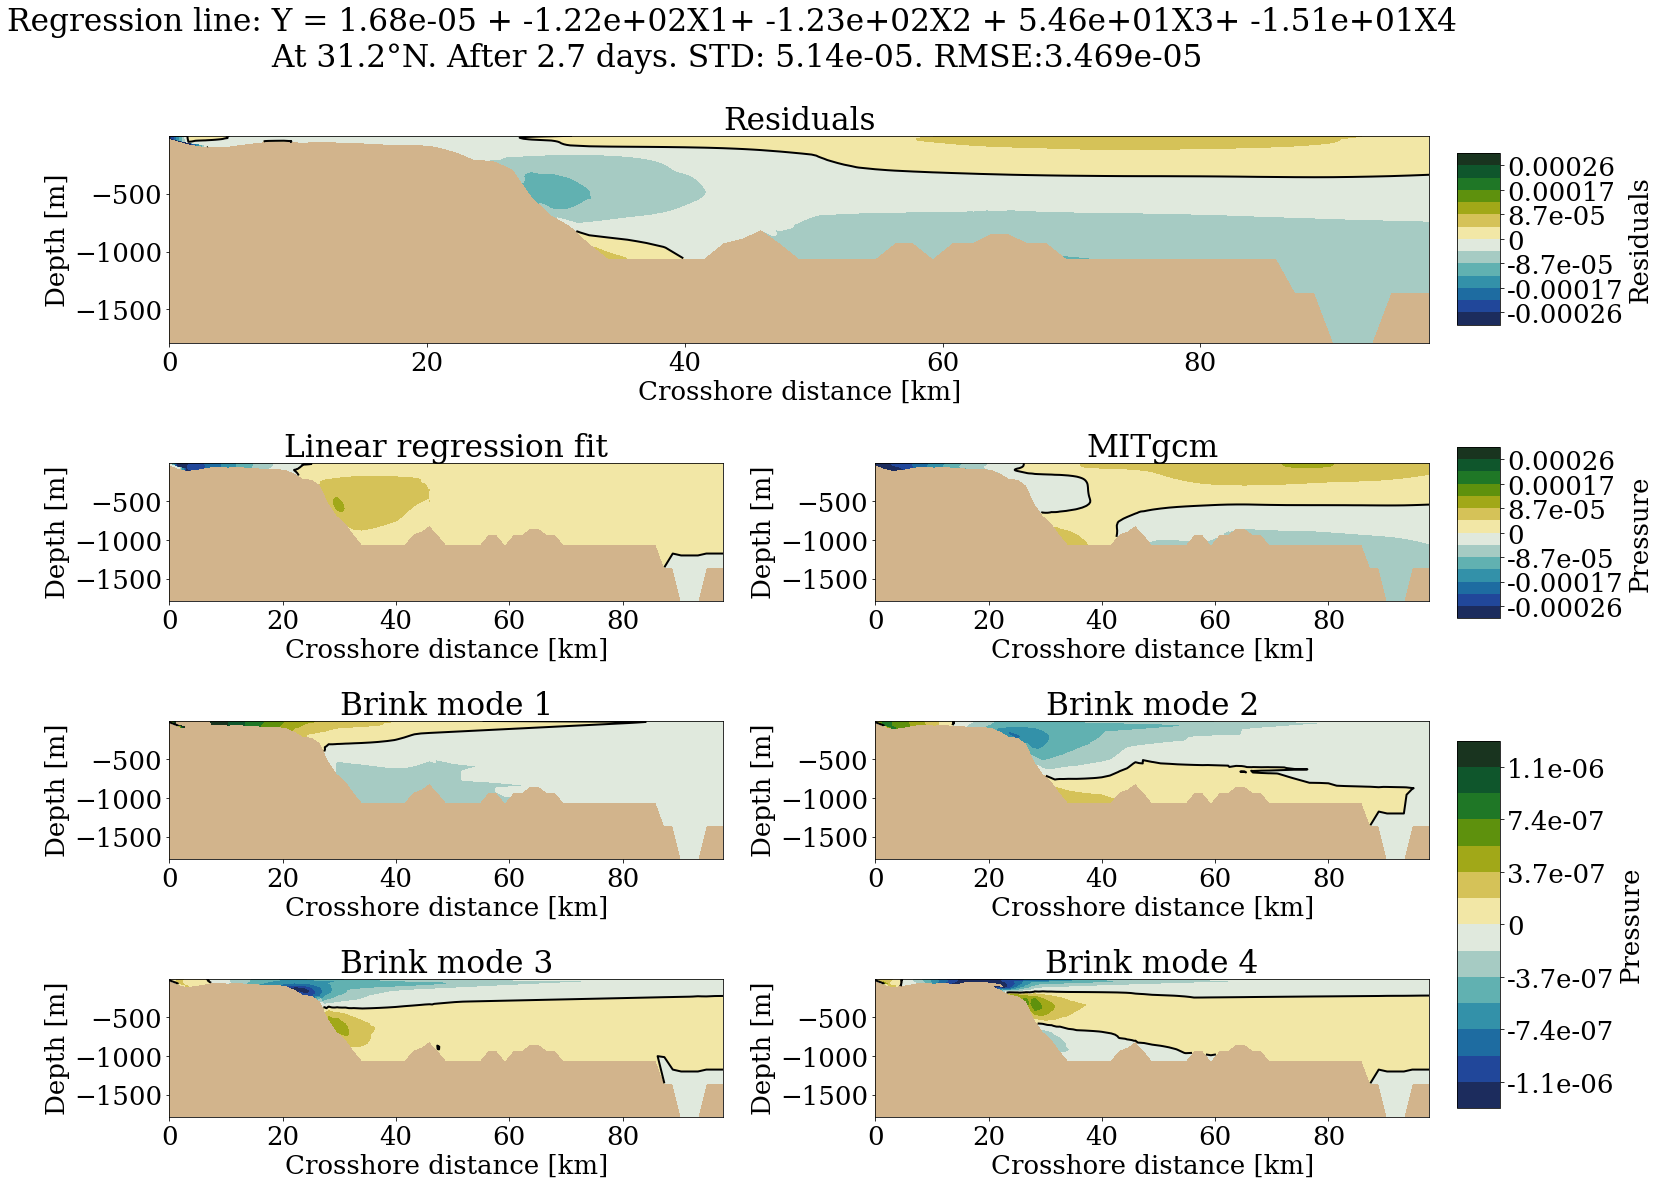

In [95]:
ind=lat_ac[85]
lat=31.20
t=100
fig = plt.figure()
LINREGplot(fig,VALmit,VALfit,varbrink1,varbrink2,varbrink3,varbrink4,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,times,BETAp,FITp,t,RMSE[t])

## Running the regression for the unfiltered data

In [19]:
ind=lat_ac[58]
lat=30.84
depths=np.arange(71,0,-1)
Z=dsw[0].Zl[depths].values
filt=0
VALFITp=np.zeros((72*5+144*3,np.size(VALfit[1,:,0]),np.size(VALfit[1,0,:])))
VALMITp=np.zeros((72*5+144*3,np.size(VALfit[1,:,0]),np.size(VALfit[1,0,:])))
FITp=np.zeros((72*5+144*3))
RMSEp=np.zeros((72*5+144*3))
BETAp=np.zeros((72*5+144*3,5))
for tt in np.arange(0,8,1):
    VALfitorg,betasorg,xbetaorg,yhatorg,dist,VALmitorg,varbrink1,varbrink2,varbrink3,varbrink4,grid_X,grid_Z,fitorg,Yorg,xpi,Ypreorg,rmseorg=fitmodes(dsw,dsn,tt,p1,p2,p3,p4,xpl,Z,z,ind,lat,h,zgr,xgr,filt,ds)
    if tt<=2:
        VALFITp[len(dsw[tt-1].PHIHYD[:,1,1])*tt:len(VALfitorg[:,1,1])*(tt+1),:,:]=VALfitorg
        VALMITp[len(dsw[tt-1].PHIHYD[:,1,1])*tt:len(VALfitorg[:,1,1])*(tt+1),:,:]=VALmitorg
        FITp[len(dsw[tt-1].PHIHYD[:,1,1])*tt:len(VALfitorg[:,1,1])*(tt+1)]=fitorg
        BETAp[len(dsw[tt-1].PHIHYD[:,1,1])*tt:len(VALfitorg[:,1,1])*(tt+1),:]=betasorg
        RMSEp[len(dsw[tt-1].PHIHYD[:,1,1])*tt:len(VALfitorg[:,1,1])*(tt+1)]=rmseorg
    else:
        VALFITp[432+len(VALfitorg)*(tt-3):432+len(VALfitorg[:,1,1])*(tt-2),:,:]=VALfitorg
        VALMITp[432+len(VALfitorg)*(tt-3):432+len(VALfitorg[:,1,1])*(tt-2),:,:]=VALmitorg
        FITp[432+len(VALfitorg)*(tt-3):432+len(VALfitorg[:,1,1])*(tt-2)]=fitorg
        BETAp[432+len(VALfitorg)*(tt-3):432+len(VALfitorg[:,1,1])*(tt-2)]=betasorg
        RMSEp[432+len(VALfitorg)*(tt-3):432+len(VALfitorg[:,1,1])*(tt-2)]=rmseorg
        

## Loading the times

In [8]:
time23=dsw[0].time.values.astype(int)
time34=dsw[1].time.values.astype(int)
time45=dsw[2].time.values.astype(int)
time56=dsw[3].time.values.astype(int)
time67=dsw[4].time.values.astype(int)
time78=dsw[5].time.values.astype(int)
time89=dsw[6].time.values.astype(int)
time910=dsw[7].time.values.astype(int)
    
Time=np.concatenate((time23, time34, time45, time56,time67, time78,time89, time910), axis=0)#, time910), axis=0)
    
times=Time*1e-9
  

## Changes over time

In [7]:
ds3084 = xr.open_dataset('NEW CROSSECTs/LinReg3084FILT.nc')
ds312 = xr.open_dataset('NEW CROSSECTs/LinReg312FILT.nc')
#ds3268 = xr.open_dataset('/Desktop/Master project/NEW CROSSECTs/LinReg3268FILT.nc')
#ds3298 = xr.open_dataset('/Desktop/Master project/NEW CROSSECTs/LinReg3298FILT.nc')

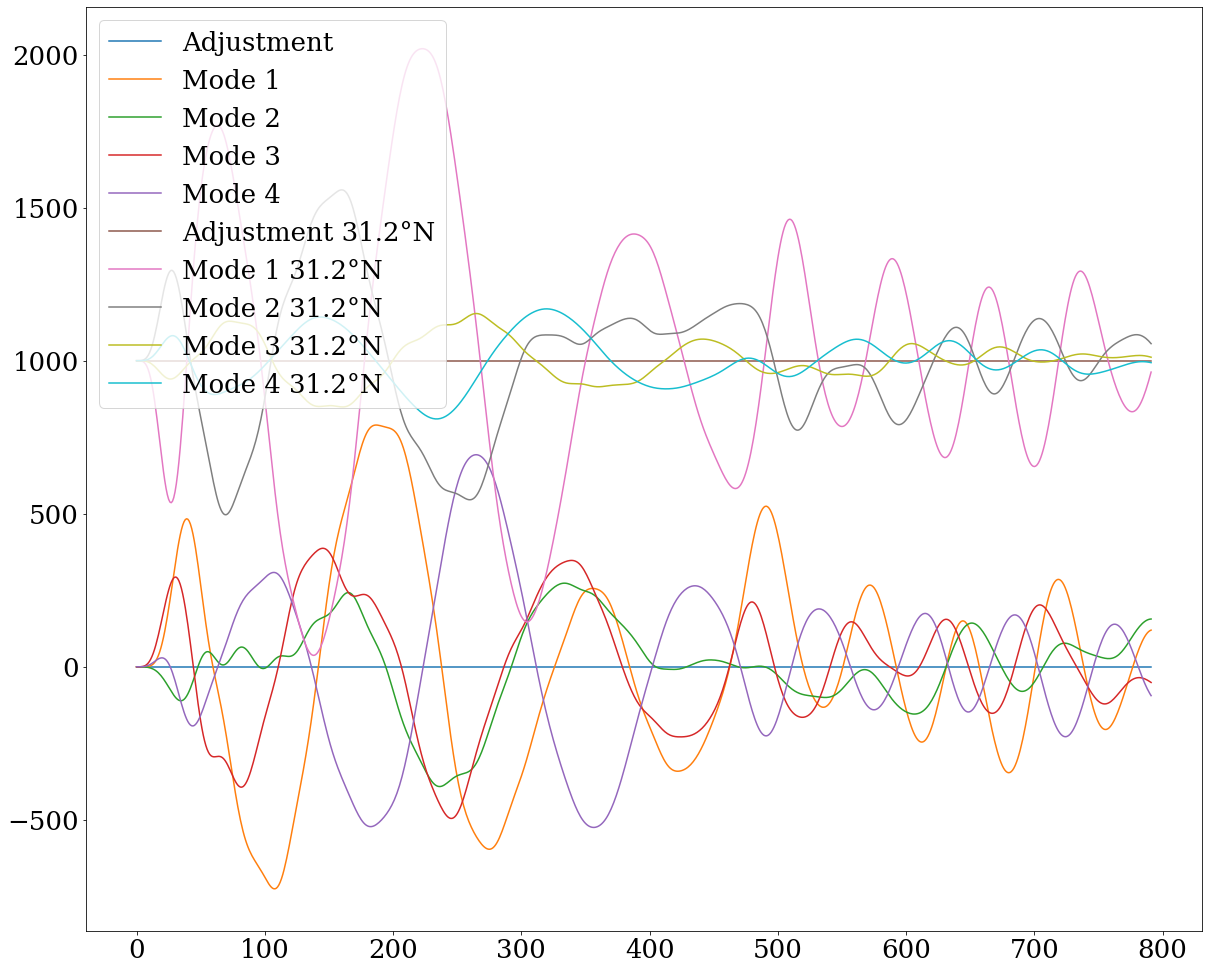

In [17]:
plt.plot(ds3084.betas.values)
plt.plot(ds312.betas.values+1000)
plt.legend(['Adjustment','Mode 1','Mode 2','Mode 3','Mode 4','Adjustment 31.2°N','Mode 1 31.2°N','Mode 2 31.2°N','Mode 3 31.2°N','Mode 4 31.2°N'])

## Visualising the fit

In [2]:
params = {'font.size': 26,
          'figure.figsize': (20, 17),
         'font.family':'serif'}
pl.rcParams.update(params)

In [36]:
dsFILT=xr.open_dataset('LinReg3084FILT.nc')
dsUNFILT=xr.open_dataset('LinReg3084.nc')

In [37]:
VALmit=dsFILT.valmit.values
VALfit=dsFILT.valfit.values
varbrink1=dsFILT.varbrink1.values
varbrink2=dsFILT.varbrink2.values
varbrink3=dsFILT.varbrink3.values
varbrink4=dsFILT.varbrink4.values
dist=dsFILT.x.values
Z=dsFILT.z.values
betas=dsFILT.betas.values
fit=dsFILT.fit.values
rmse=dsFILT.rmse.values
grid_Z=dsFILT.gridZ.values
grid_X=dsFILT.gridX.values

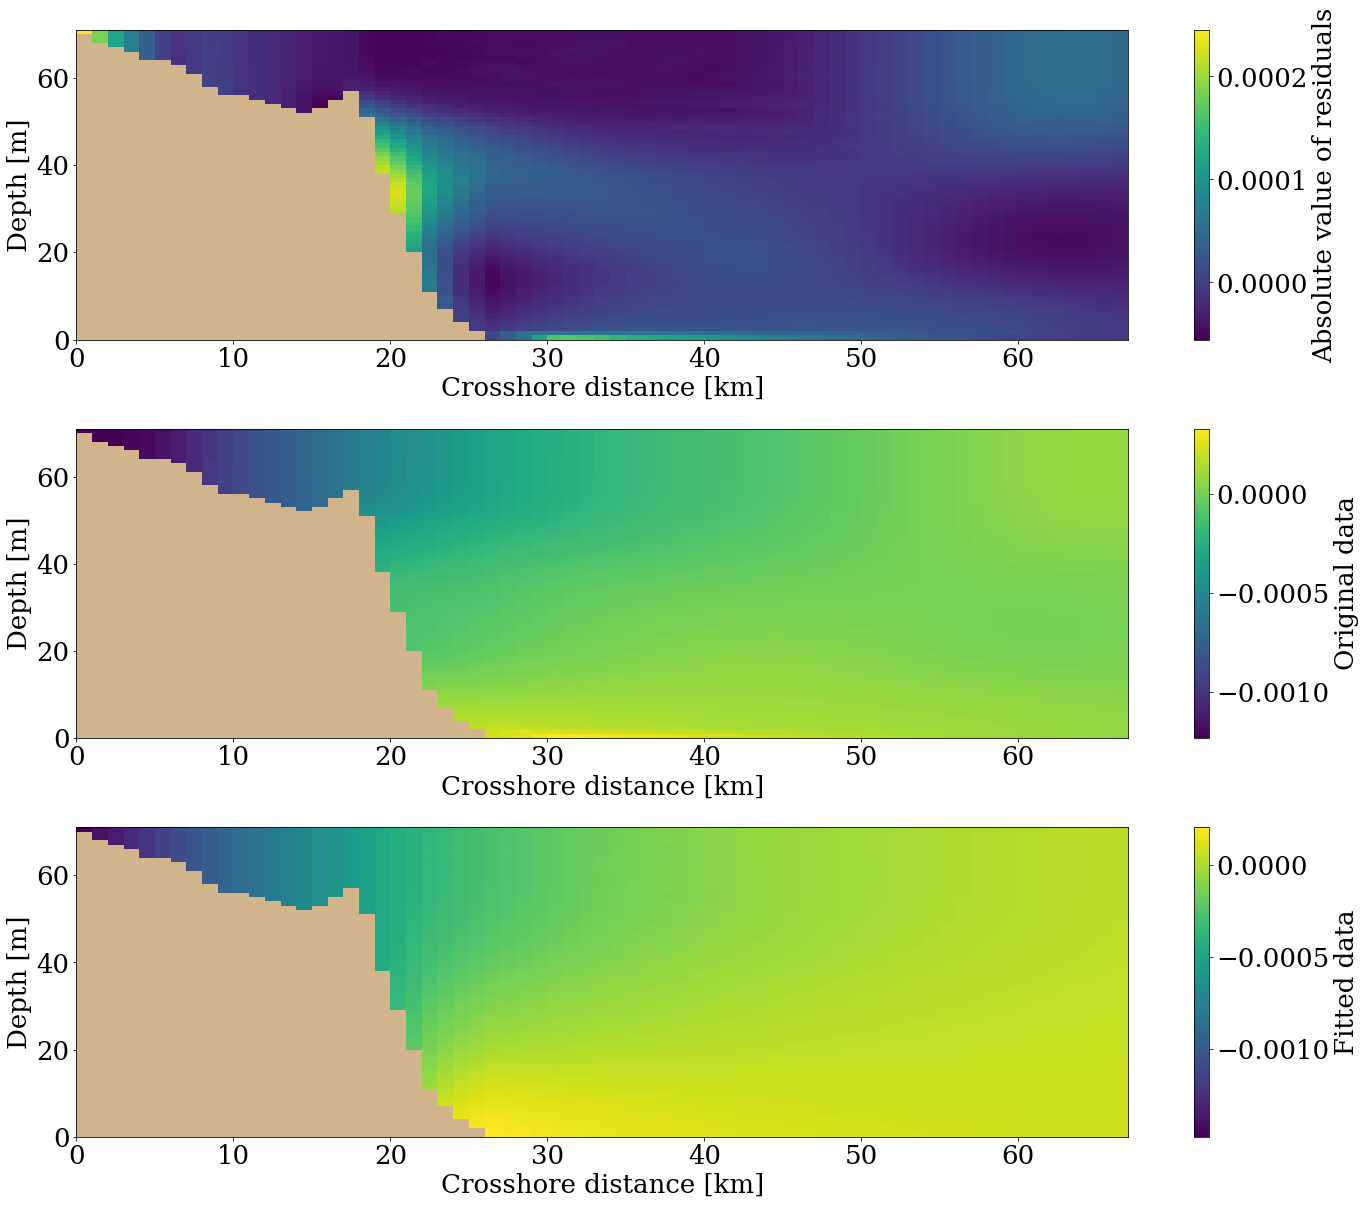

In [41]:
fig,ax=plt.subplots(3)
xlab='Crosshore distance [km]'
ylab='Depth [m]'

ax[0].set_facecolor('tan')
c=ax[0].pcolormesh(np.ma.masked_array(VALmit[t,:,:]-VALfit[t,:,:],mask=masky[:,indlon]))
cbar=plt.colorbar(c,ax=ax[0])
ax[0].set(xlabel=xlab, ylabel=ylab)
cbar.set_label('Absolute value of residuals')

ax[1].set_facecolor('tan')
c1=ax[1].pcolormesh(np.ma.masked_array(VALmit[t,:,:],mask=masky[:,indlon]))
cbar1=plt.colorbar(c1,ax=ax[1])
ax[1].set(xlabel=xlab, ylabel=ylab)
cbar1.set_label('Original data')

ax[2].set_facecolor('tan')
c2=ax[2].pcolormesh(np.ma.masked_array(VALfit[t,:,:],mask=masky[:,indlon]))
cbar2=plt.colorbar(c2,ax=ax[2])
ax[2].set(xlabel=xlab, ylabel=ylab)
cbar2.set_label('Fitted data')

#fig.suptitle(f'RMSE= {RMSE[t]}')

fig.tight_layout()

## Comparing filtered to unfiltered

In [10]:
dsFILT=xr.open_dataset('LinReg3084FILT.nc')
dsUNFILT=xr.open_dataset('LinReg3084.nc')

In [12]:
betafilt=dsFILT.betas.values
betaunfilt=dsUNFILT.betas.values
rmsefilt=dsFILT.rmse.values
rmseunfilt=dsUNFILT.rmse.values

In [13]:
DOMmodeunfilt=np.zeros(len(betafilt[:,1]))
DOMmodefilt=np.zeros(len(betafilt[:,1]))
for l in np.arange(len(betafilt[:,1])):
    DOMmodeunfilt[l]=np.argmax(betaunfilt[l,:])
    DOMmodefilt[l]=np.argmax(betafilt[l,:])

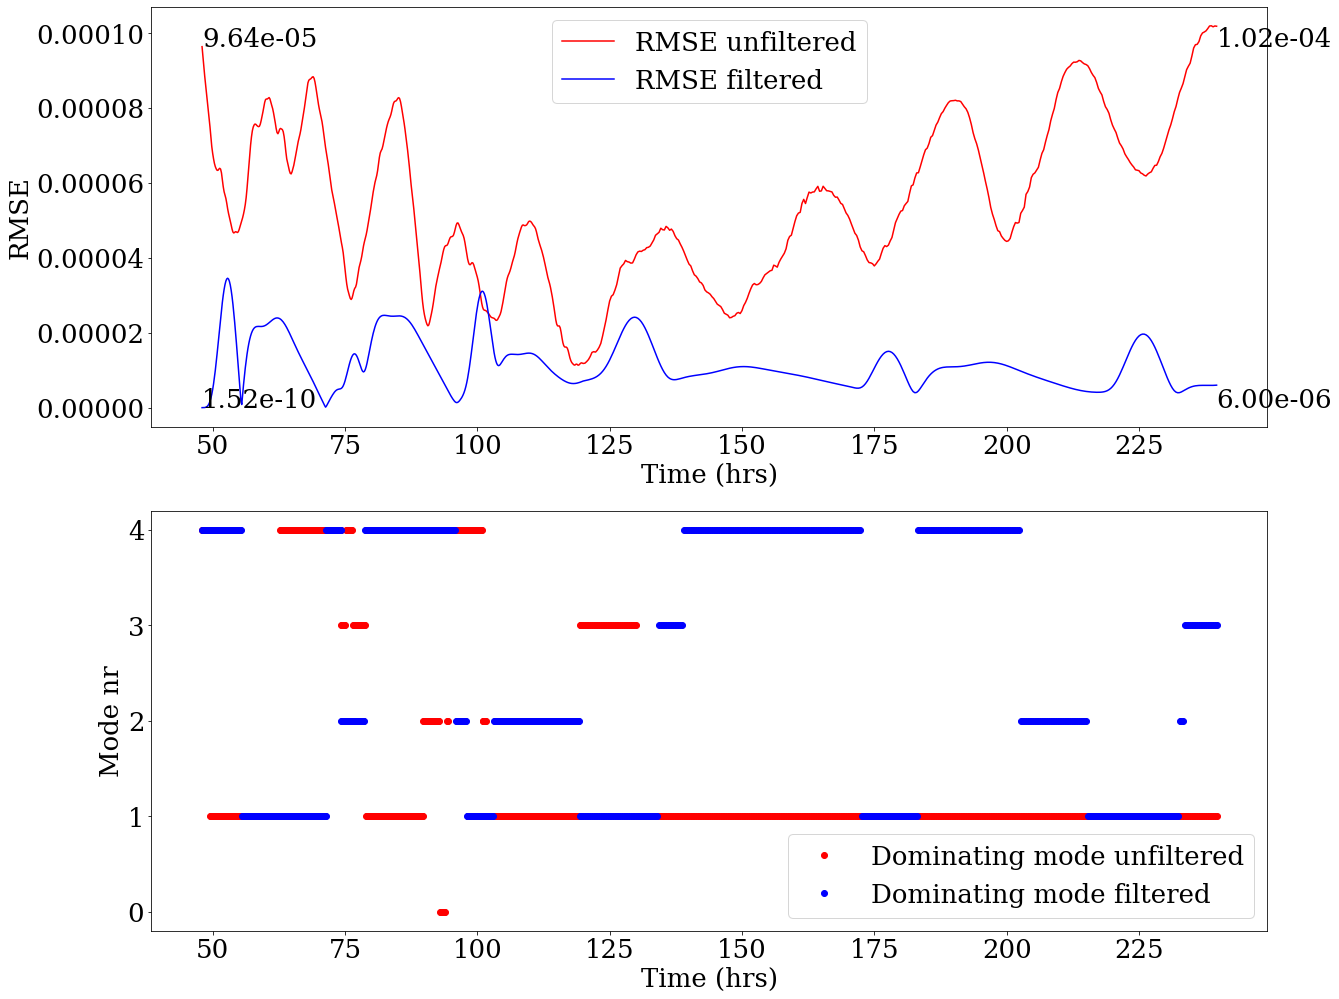

In [17]:
fig,ax=plt.subplots(2)
ax[0].plot(times/60,rmseunfilt,color='r',label='RMSE unfiltered')
ax[0].plot(times/60,rmsefilt,color='b',label='RMSE filtered')
ax[0].set(xlabel='Time (hrs)', ylabel='RMSE')
ax[0].annotate(f'{rmsefilt[0]:.2e}',(times[0]/60,rmsefilt[0]))
ax[0].annotate(f'{rmseunfilt[0]:.2e}',(times[0]/60,rmseunfilt[0]))
ax[0].annotate(f'{rmsefilt[-1]:.2e}',(times[-1]/60,rmsefilt[0]))
ax[0].annotate(f'{rmseunfilt[-1]:.2e}',(times[-1]/60,rmseunfilt[0]))

ax[0].legend()
ax[1].plot(times/60,DOMmodeunfilt,'or',label='Dominating mode unfiltered')
ax[1].plot(times/60, DOMmodefilt,'ob',label='Dominating mode filtered')
ax[1].set(xlabel='Time (hrs)', ylabel='Mode nr')
ax[1].legend()

## Saving the regression values

In [20]:
FILENAME='LinReg3084.nc'
ds = xr.Dataset({'valfit': (("time","z","x"), VALFITp),
                 'valmit': (("time","z","x"), VALMITp),
                 'varbrink1': (("z","x"), varbrink1),
                 'varbrink2': (("z","x"), varbrink2),
                 'varbrink3': (("z","x"), varbrink3),
                 'varbrink4': (("z","x"), varbrink4),
                 'fit':(("time"), FITp),
                 'gridX':(("z","x"), grid_X),
                 'gridZ':(("z","x"), grid_Z),
                 'betas':(("time","nrB"), BETAp),
                 'rmse':(("time"), RMSEp)
                    },
                coords ={
                    "x" : dist.values,
                    "z" : Z,
                    "time": times,
                    "nrB": np.arange(0,5,1)
                },
                )
ds.to_netcdf(FILENAME)

In [98]:
FILENAME='/home/amelia/Master project/NEW CROSSECTs/LinReg312FILT.nc'
ds = xr.Dataset({'valfit': (("time","z","x"), VALfit),
                 'valmit': (("time","z","x"), VALmit),
                 'varbrink1': (("z","x"), varbrink1),
                 'varbrink2': (("z","x"), varbrink2),
                 'varbrink3': (("z","x"), varbrink3),
                 'varbrink4': (("z","x"), varbrink4),
                 'fit':(("time"), fit),
                 'gridX':(("z","x"), grid_X),
                 'gridZ':(("z","x"), grid_Z),
                 'betas':(("time","nrB"), betas),
                 'rmse':(("time"), RMSE)
                    },
                coords ={
                    "x" : dist.values,
                    "z" : Z,
                    "time": times,
                    "nrB": np.arange(0,5,1)
                },
                )
ds.to_netcdf(FILENAME)

## Probability density  function

In [25]:
var=np.mean((Y - np.mean(Y)) ** 2)
distr=(1/(np.sqrt(var)*np.sqrt(2*np.pi)))*np.exp(-(1/2)*((Y-np.mean(Y))/np.sqrt(var))**2)

Text(0, 0.5, 'Probability density')

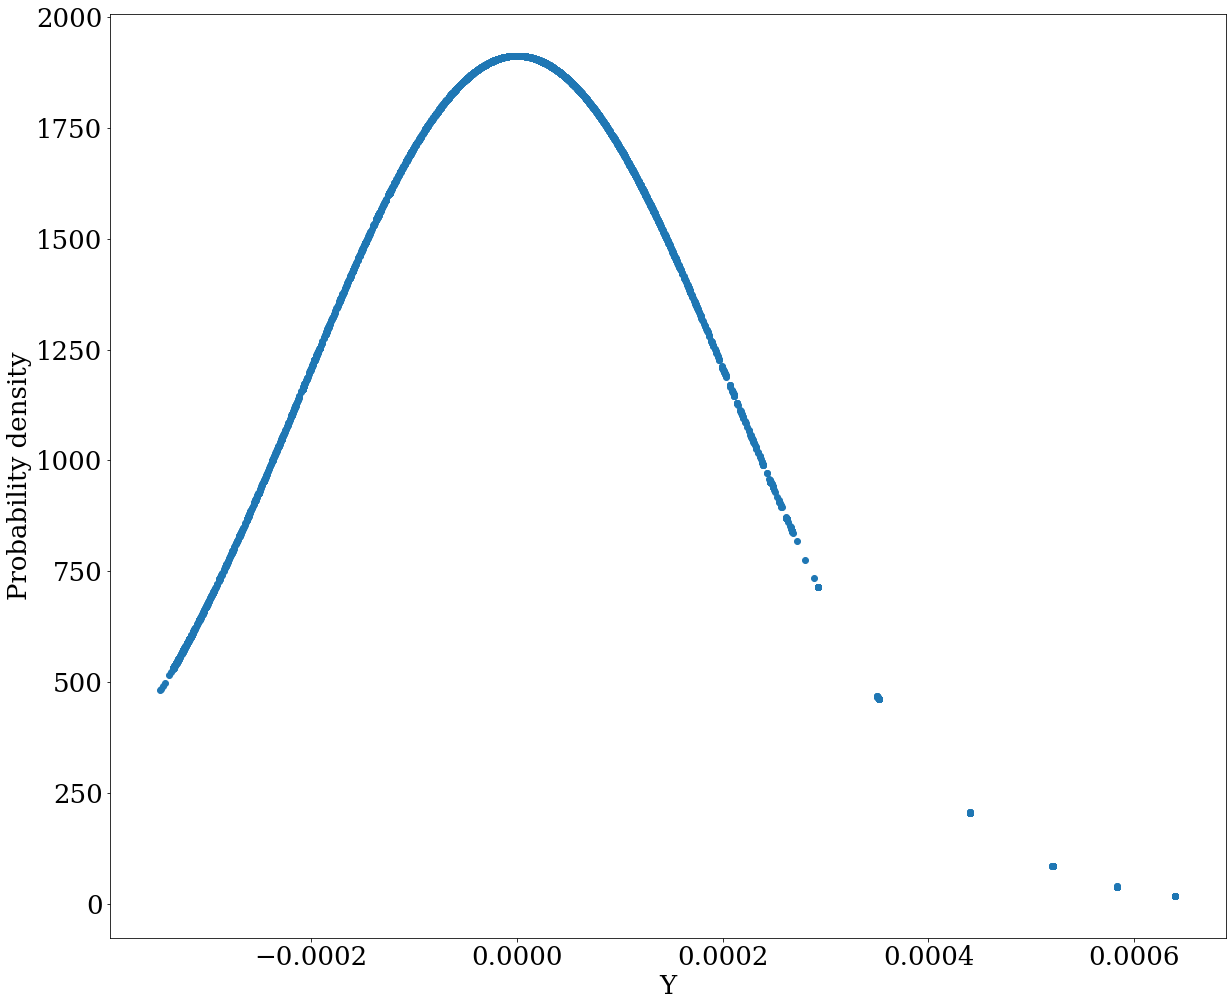

In [26]:
plt.scatter(Y,distr)
plt.xlabel('Y')
plt.ylabel('Probability density')

## Filtering

In [62]:
Z=dsw[0].Zl.values

In [75]:
ind=lat_ac[58]
lat=30.84
hFacC = dsw[0].hFacC
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
    
coast=np.where(mask[0,ind,:]==False)
    
LON = dsw[0].XC[coast]-360

distance=cos((lat*np.pi)/180)*111*-1*(LON-LON[-1])
if lat>32:
    indlonpre=np.where(distance<=80)
else:
    indlonpre=np.where(distance<=99)
indlon=np.flip(indlonpre[0])
#actual distance from the coast
distpre=distance[indlon]
dist=distpre
    
maskin=mask[:,ind,indlon]
VALMITpre=np.zeros((72*5+144*3,np.size(maskin[:,0]),np.size(maskin[0,:])))

for tt in np.arange(0,8,1):
    
    VALMIT=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1]),len(Z),len(dist)))
    
    for t in np.arange(0,len(dsw[tt].PHIHYD[:,1,1,1]),1):
        VALb=dsw[tt].PHIHYD[t,:,ind,indlon].values
        VALn=dsn[tt].PHIHYD[t,:,ind,indlon].values
        VALmit=VALb-VALn
        VALMIT[t,:,:]=VALmit
        
    if tt<=2:
        VALMITpre[len(dsw[tt-1].PHIHYD[:,1,1,1])*tt:len(VALMIT[:,1,1])*(tt+1),:,:]=VALMIT
    else:
        VALMITpre[432+len(VALMIT[:,1,1])*(tt-3):432+len(VALMIT[:,1,1])*(tt-2),:,:]=VALMIT
        


In [76]:
VALfilt=np.zeros((72*8,np.size(VALMITpre[0,:,0]),np.size(VALMITpre[0,0,:])))
order = 3
fs = 1/1200       
cutoff =np.array([1/432000, 1/43200])
ttwenty=np.append(np.arange(0,432,2), np.arange(432,len(times),1)) #making it only take every twenty minutes 
                                                                   # so we can apply the same frequency on all     

for d in np.arange(np.size(VALMITpre,1)):
    for k in np.arange(np.size(VALMITpre,2)):
        data = VALMITpre[ttwenty,d,k]
        VALfilt[:,d,k] = butter_lowpass_filter(data, cutoff, fs, order)

In [34]:
def butter_lowpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sig.butter(order, normal_cutoff, btype='bandpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=3):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sig.filtfilt(b, a, data)
    return y

In [77]:
FILENAME='/home/amelia/Master project/Crossects/PHIHYD3084.nc'
ds = xr.Dataset({'VALmit': (("time","z","x"), VALMITpre)
                    },
                coords ={
                    "x" : dist.values,
                    "z" : Z,
                    "time": times
                },
                )
ds.to_netcdf(FILENAME)

In [78]:
FILENAME='/home/amelia/Master project/Crossects/PHIHYD3084filt.nc'
ds = xr.Dataset({'VALfilt': (("time","z","x"), VALfilt)
                    },
                coords ={
                    "x" : dist.values,
                    "z" : Z,
                    "time": times[ttwenty]
                },
                )
ds.to_netcdf(FILENAME)

# Pressure

In [16]:
params = {'font.size': 26,
          'figure.figsize': (20, 17),
         'font.family':'serif'}
pl.rcParams.update(params)

### At 30.84 degrees north

##### How is the fit? 

In [57]:
ds = xr.open_dataset('LinReg3084FILT.nc')

In [58]:
VALMITp=ds.valmit
VALFITp=ds.valfit
varbrink1=ds.varbrink1
varbrink2=ds.varbrink2
varbrink3=ds.varbrink3
varbrink4=ds.varbrink4
BETAp=ds.betas.values
FITp=ds.fit.values
grid_Z=ds.gridZ
grid_X=ds.gridX
dist=ds.x
Z=ds.z
TIME=ds.time.values
RMSE=ds.rmse.values

MaskError: Mask and data not compatible: data size is 4757, mask size is 5092.

<Figure size 1440x1224 with 0 Axes>

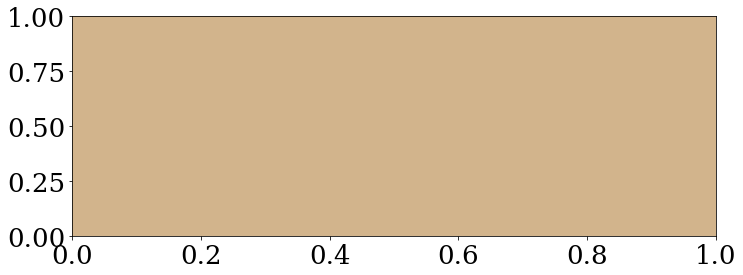

In [26]:
ind=lat_ac[58]
lat=30.84
t=500
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,varbrink1,varbrink2,varbrink3,varbrink4,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,times,BETAp,FITp,t,RMSE[t])

### At 31.20 degrees north

In [114]:
ds = xr.open_dataset('LinReg3120FILT.nc')

In [115]:
VALMITp=ds.valmit
VALFITp=ds.valfit
varbrink1=ds.varbrink1
varbrink2=ds.varbrink2
varbrink3=ds.varbrink3
varbrink4=ds.varbrink4
BETAp=ds.betas.values
FITp=ds.fit.values
grid_Z=ds.gridZ
grid_X=ds.gridX
dist=ds.x
Z=ds.z
TIME=ds.time.values
RMSE=ds.rmse.values

<Figure size 1440x1224 with 0 Axes>

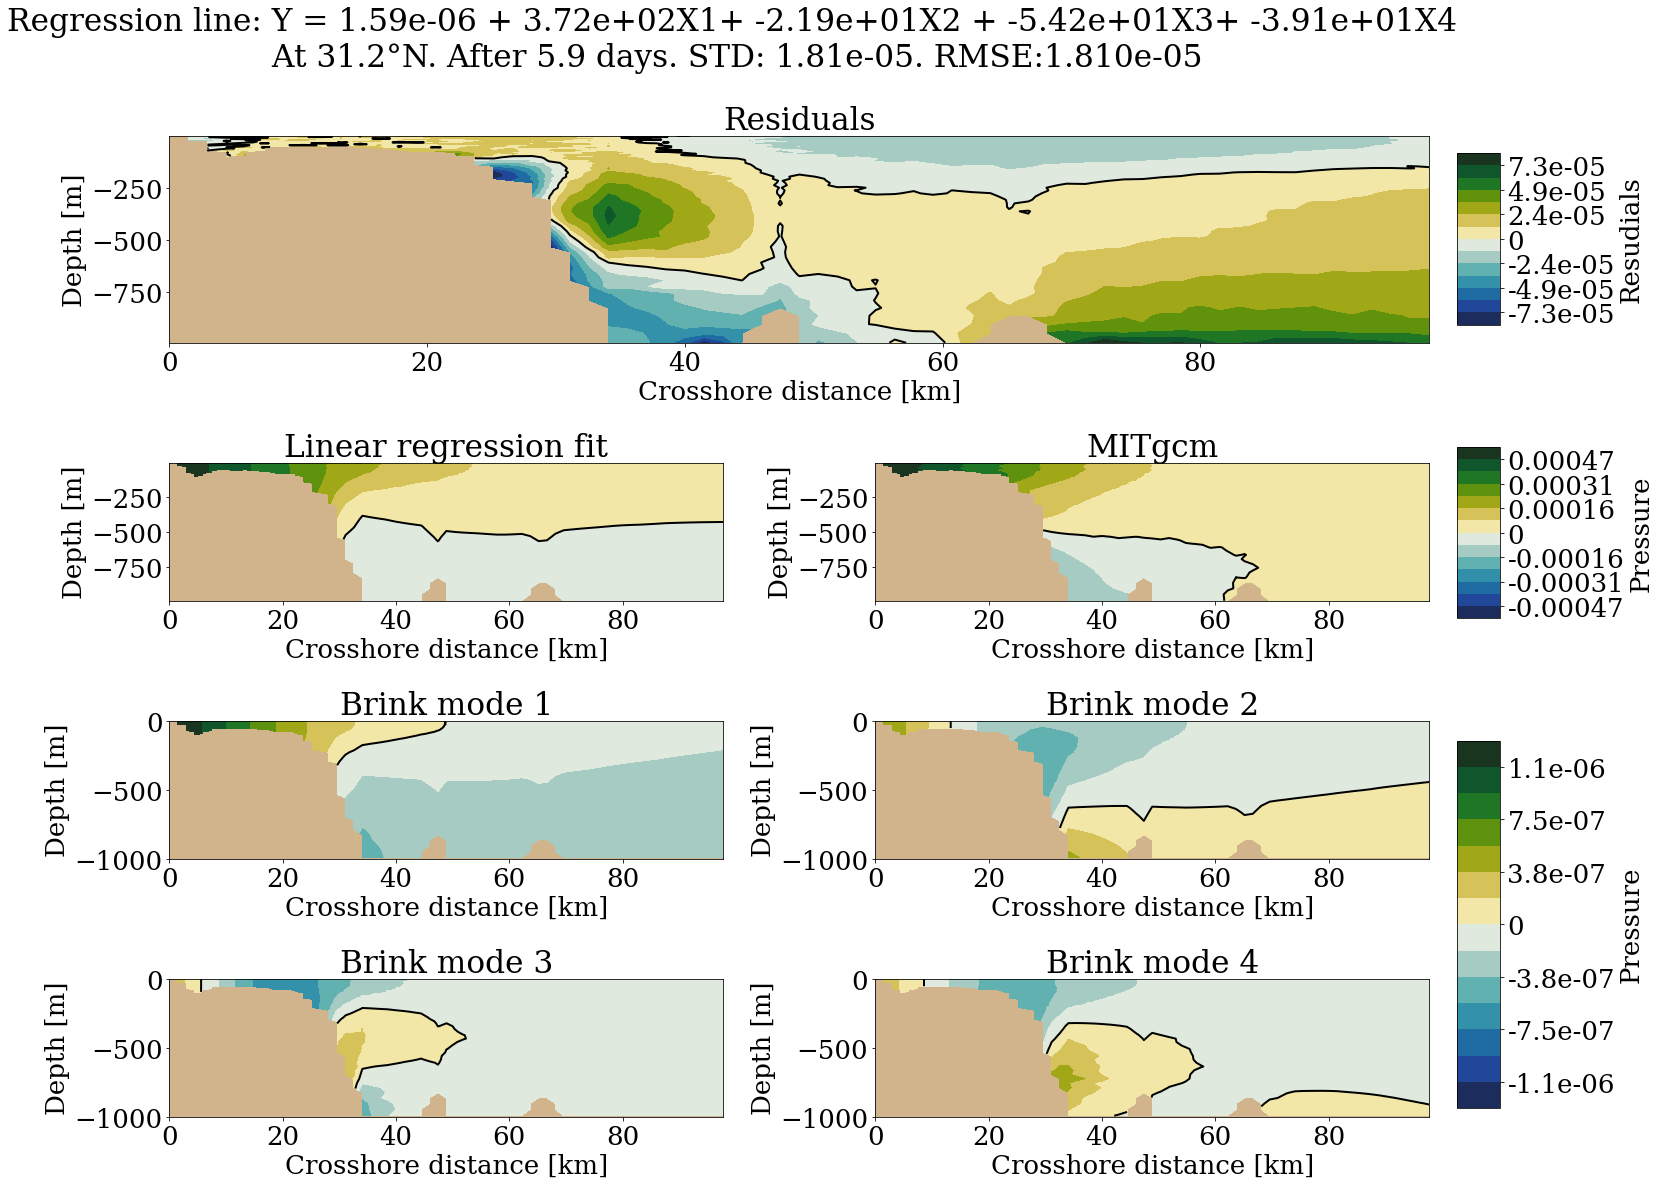

In [116]:
ind=lat_ac[85]
lat=31.20
t=500
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,varbrink1,varbrink2,varbrink3,varbrink4,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,times,BETAp,FITp,t,RMSE[t])

### At 32.68 degrees north

##### How is the fit? 

In [50]:
ds = xr.open_dataset('LinReg3268FILT.nc')

In [51]:
VALMITp=ds.valmit
VALFITp=ds.valfit
varbrink1=ds.varbrink1
varbrink2=ds.varbrink2
varbrink3=ds.varbrink3
varbrink4=ds.varbrink4
BETAp=ds.betas.values
FITp=ds.fit.values
grid_Z=ds.gridZ
grid_X=ds.gridX
dist=ds.x
Z=ds.z
TIME=ds.time.values
RMSE=ds.rmse.values

<Figure size 1440x1224 with 0 Axes>

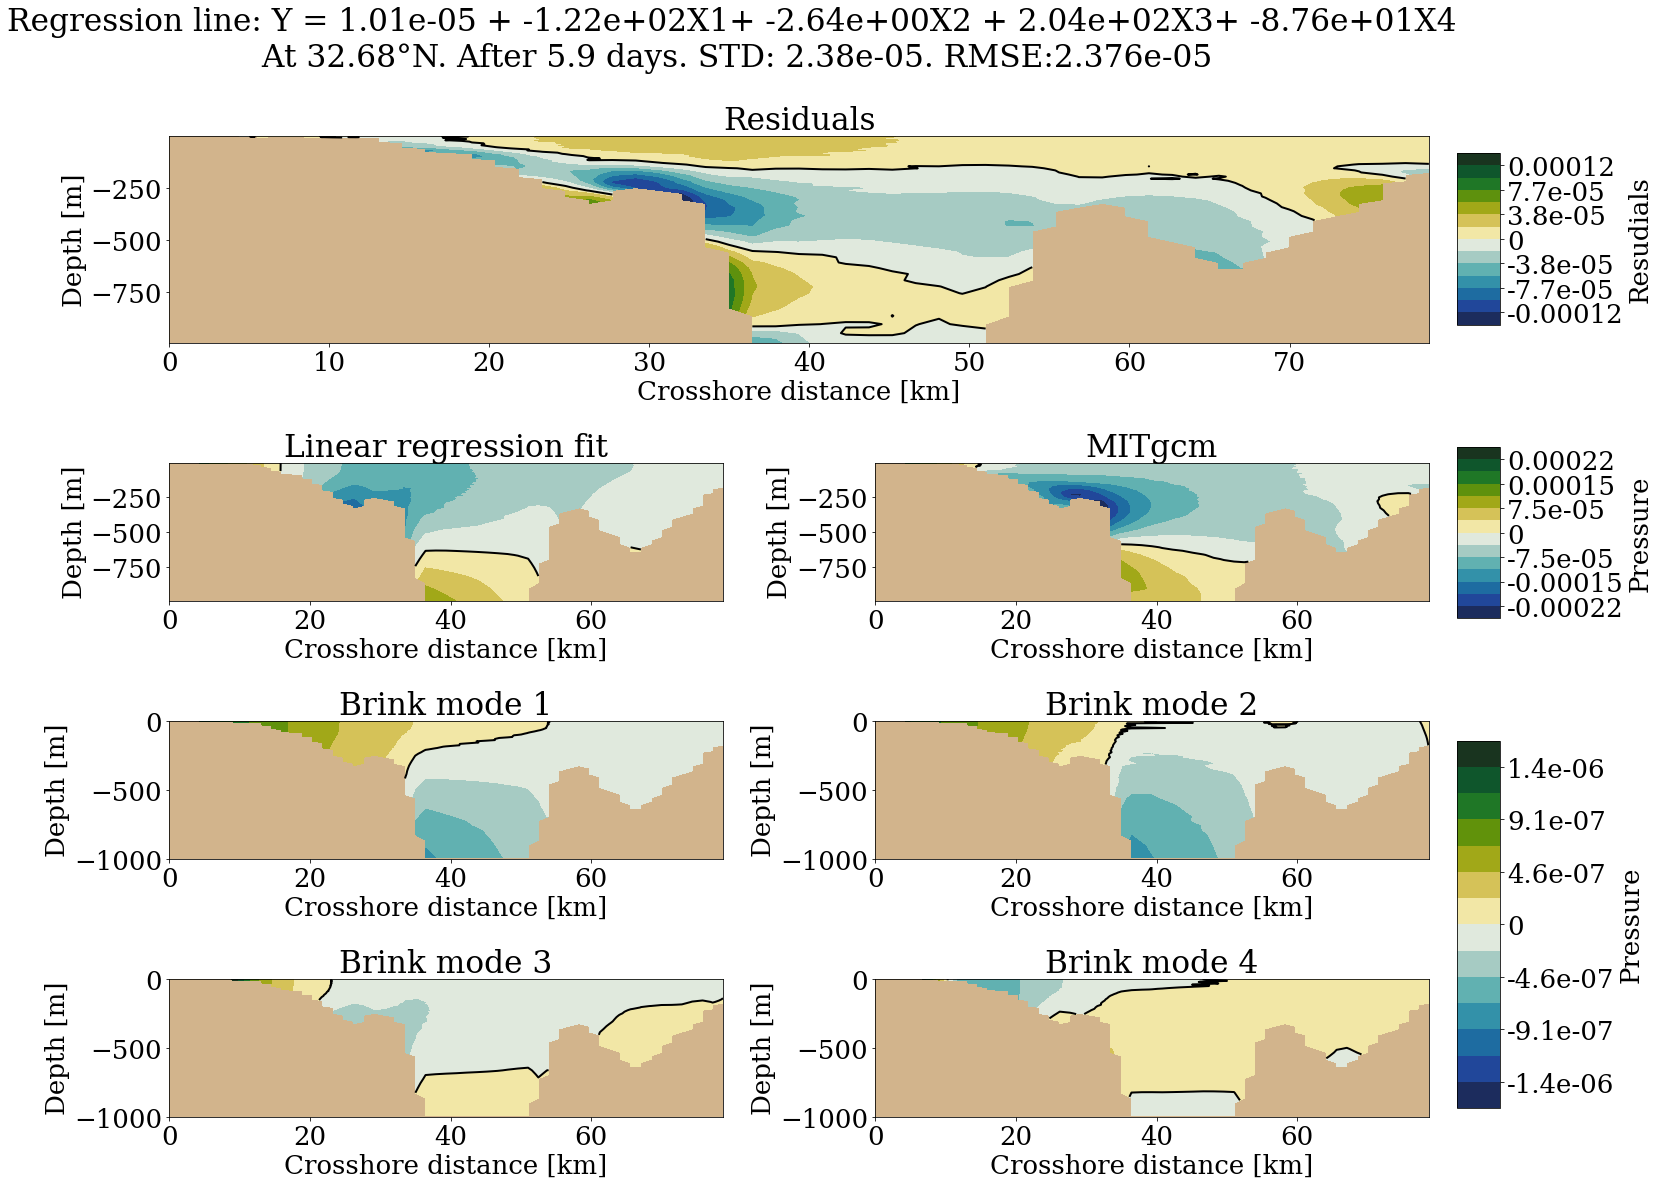

In [119]:
ind=lat_ac[205]
lat=32.68
t=500
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,varbrink1,varbrink2,varbrink3,varbrink4,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,times,BETAp,FITp,t,RMSE[t])

### At 32.98 degrees north

##### How is the fit? 

In [120]:
ds = xr.open_dataset('LinReg3298FILT.nc')

In [121]:
VALMITp=ds.valmit
VALFITp=ds.valfit
varbrink1=ds.varbrink1
varbrink2=ds.varbrink2
varbrink3=ds.varbrink3
varbrink4=ds.varbrink4
BETAp=ds.betas.values
FITp=ds.fit.values
grid_Z=ds.gridZ
grid_X=ds.gridX
dist=ds.x
Z=ds.z
TIME=ds.time.values
RMSE=ds.rmse.values

<Figure size 1440x1224 with 0 Axes>

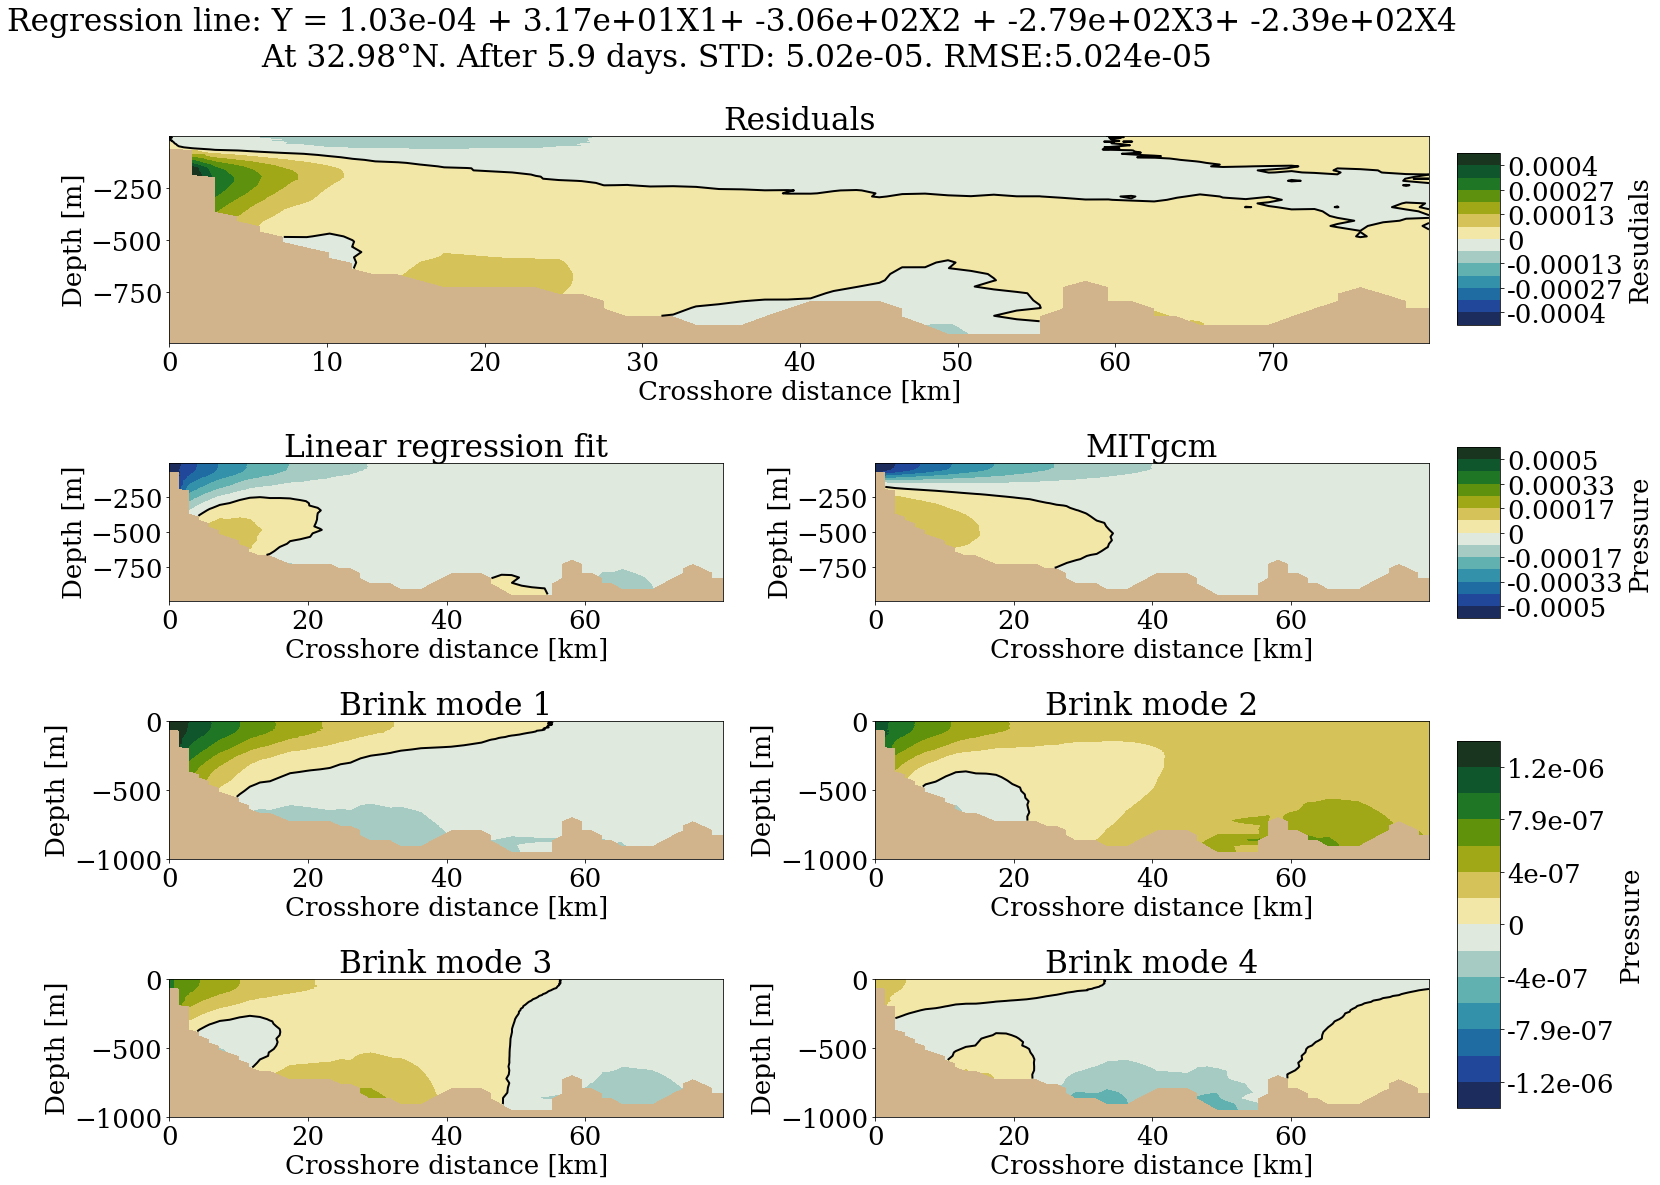

In [122]:
ind=lat_ac[227]
lat=32.98
t=500
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,varbrink1,varbrink2,varbrink3,varbrink4,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,times,BETAp,FITp,t,RMSE[t])

### Show interpolation success

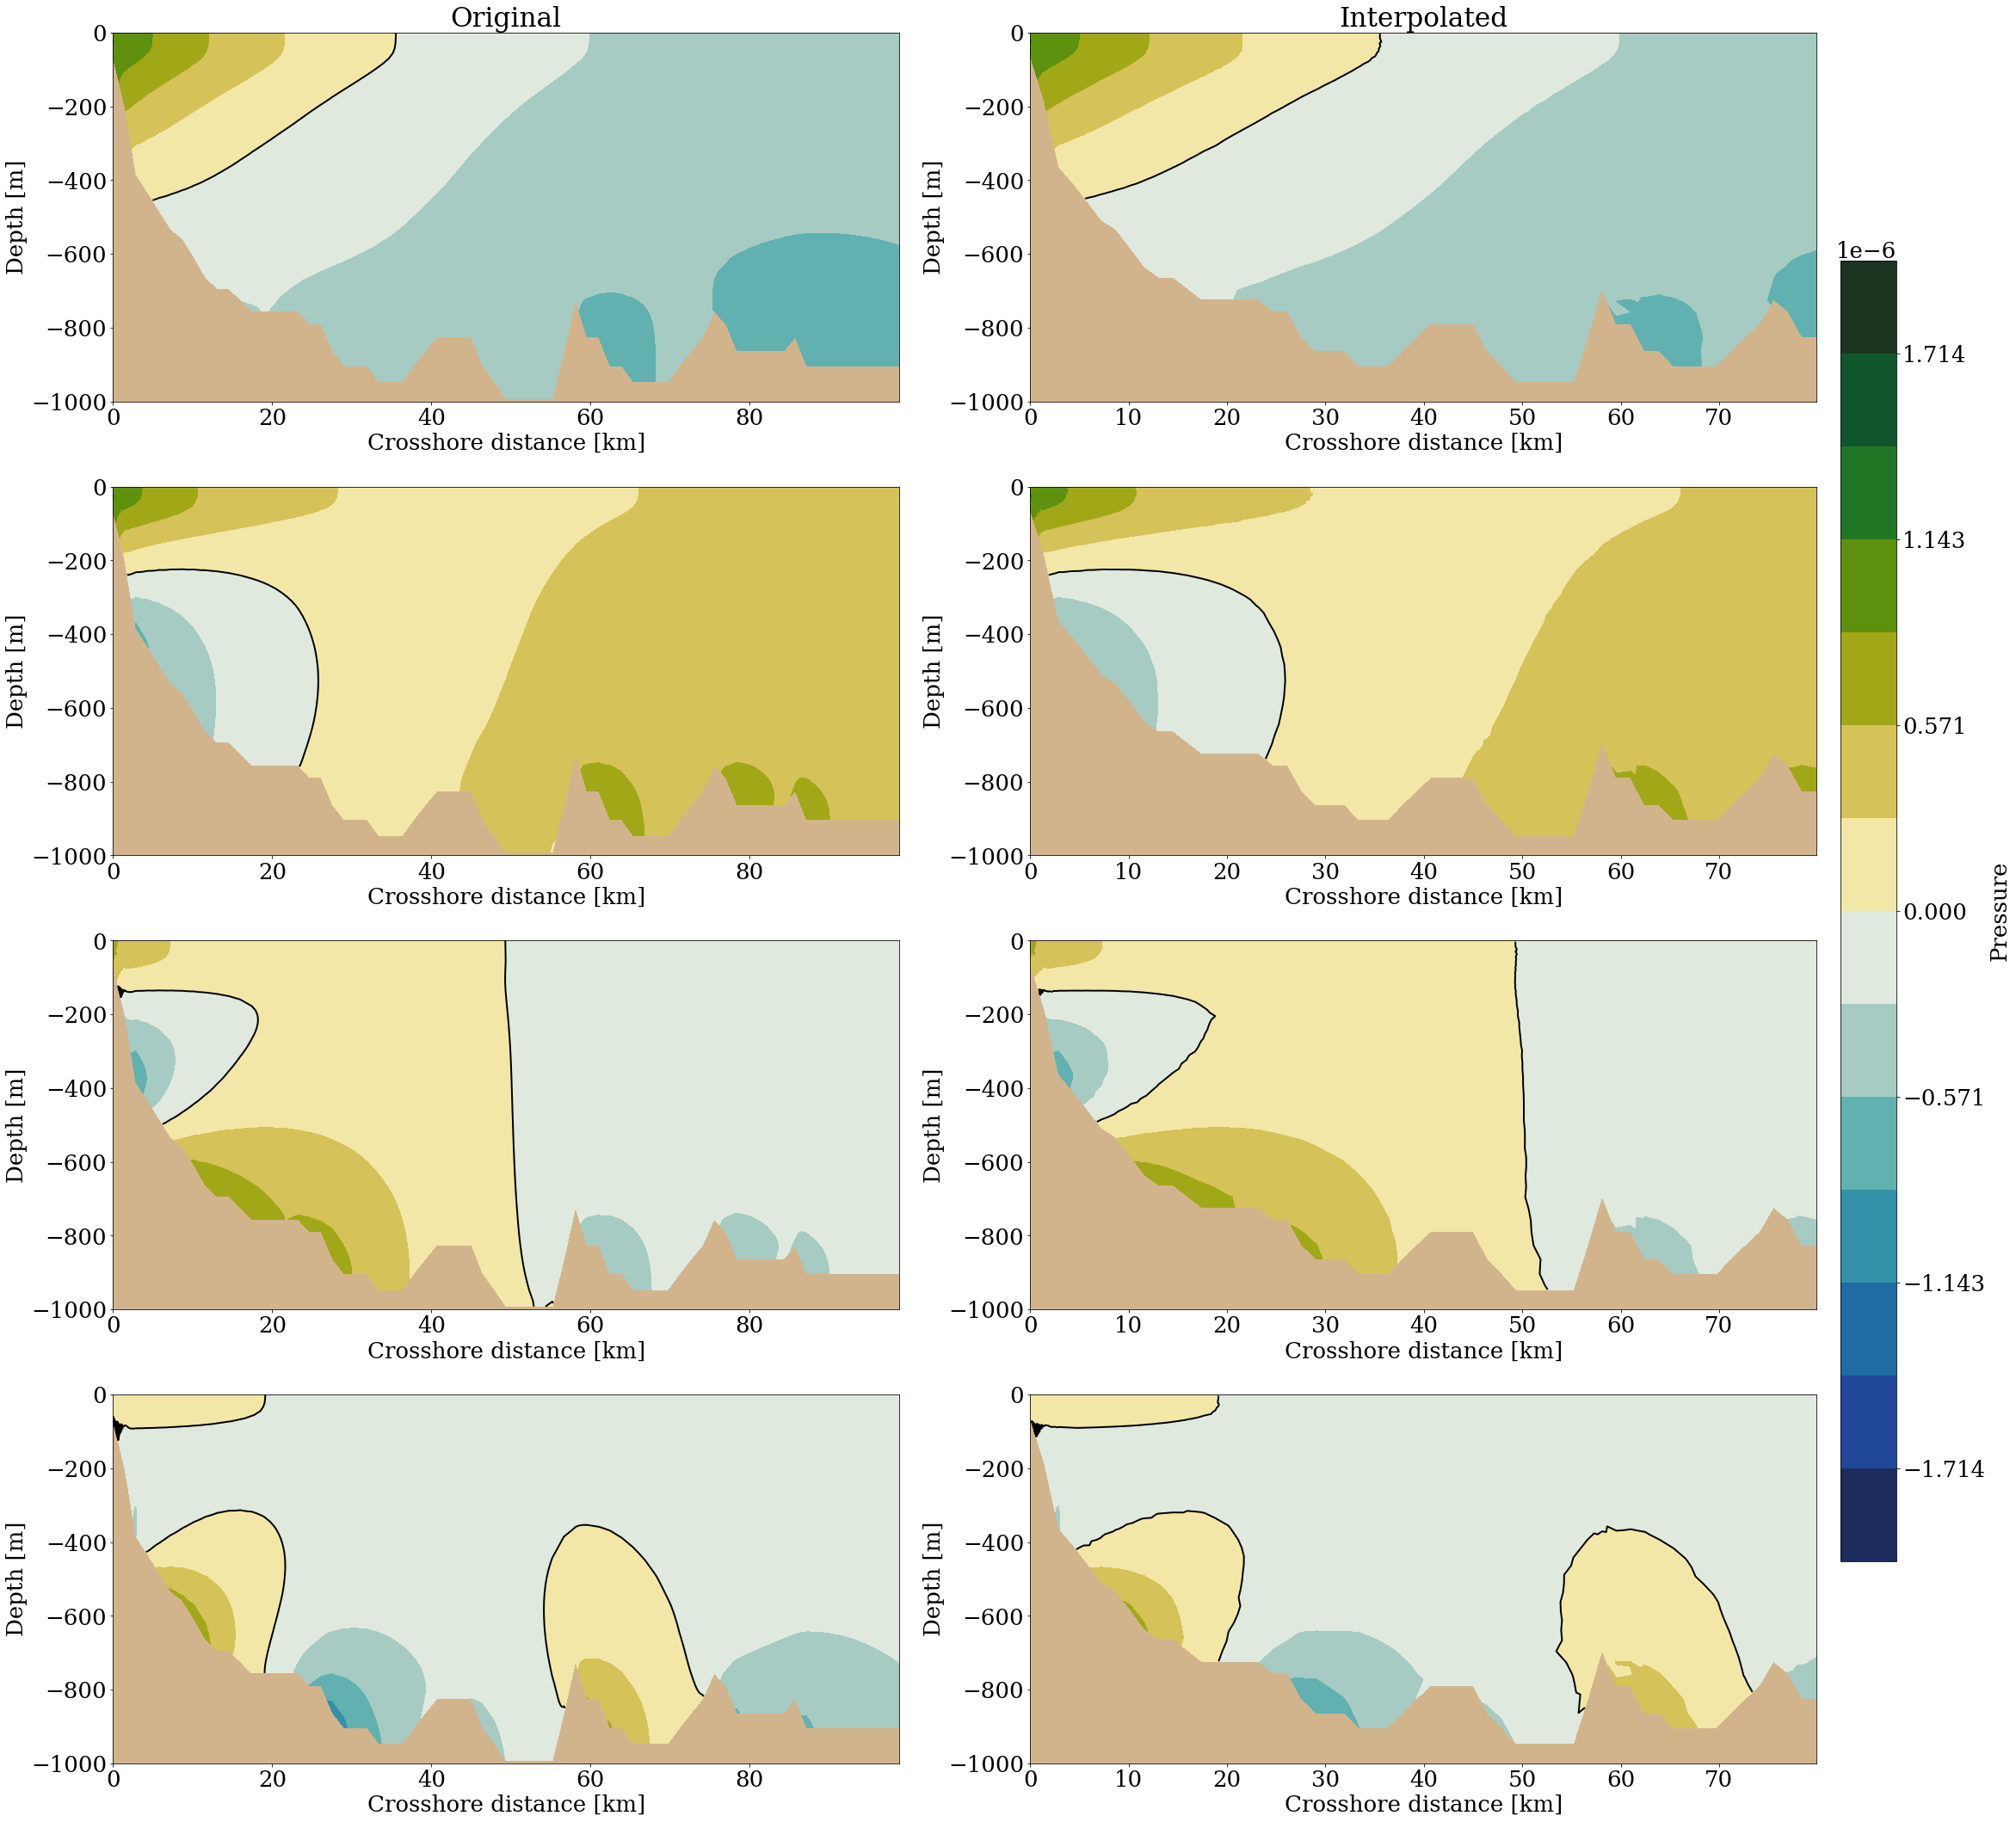

In [74]:
fig = plt.figure(figsize=(30, 30))
gs = GridSpec(nrows=4, ncols=2, height_ratios=[1, 1,1,1,])#,wspace=0.6)
xlab='Crosshore distance [km]'
ylab='Depth [m]'

vmin= -2e-6
vmax=2e-6
levels2=np.linspace(vmin,vmax,15)

vmin= -2e-6
vmax=2e-6
levels=np.linspace(vmin,vmax,15)

masky=mask[depths,ind,:]

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor('tan')
cax1=ax0.contourf(xgr,zgr,p1,cmap=cmocean.cm.delta,levels=levels)
ax0.contour(xgr, zgr,p1, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax0.set(xlabel=xlab, ylabel=ylab)
ax0.set_title('Original')
ax0.set_ylim([-1000,0])
#ax0.set_xlim([0,80])

ax1 = fig.add_subplot(gs[0, 1])
ax1.set_facecolor('tan')
ax1.contourf(grid_X,grid_Z,varbrink1,cmap=cmocean.cm.delta,levels=levels2)
ax1.contour(grid_X,grid_Z,varbrink1, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax1.set(xlabel=xlab, ylabel=ylab)
ax1.set_title('Interpolated')
ax1.set_ylim([-1000,0])
#ax1.set_xlim([0,80])

ax2 = fig.add_subplot(gs[1,0])
ax2.set_facecolor('tan')
ax2.contourf(xgr,zgr,p2,cmap=cmocean.cm.delta,levels=levels)
ax2.contour(xgr, zgr,p2, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax2.set(xlabel=xlab, ylabel=ylab)
ax2.set_ylim([-1000,0])
#ax2.set_xlim([0,80])

ax3 = fig.add_subplot(gs[1, 1])
ax3.set_facecolor('tan')
ax3.contourf(grid_X,grid_Z,varbrink2,cmap=cmocean.cm.delta,levels=levels2)
ax3.contour(grid_X,grid_Z,varbrink2, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax3.set(xlabel=xlab, ylabel=ylab)
ax3.set_ylim([-1000,0])
#ax3.set_xlim([0,80])

ax4 = fig.add_subplot(gs[2, 0])
ax4.set_facecolor('tan')
ax4.contourf(xgr,zgr,p3,cmap=cmocean.cm.delta,levels=levels)
ax4.contour(xgr, zgr,p3, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax4.set(xlabel=xlab, ylabel=ylab)
ax4.set_ylim([-1000,0])
#ax4.set_xlim([0,80])
             
ax5 = fig.add_subplot(gs[2, 1])
ax5.set_facecolor('tan')
ax5.contourf(grid_X,grid_Z,varbrink3,cmap=cmocean.cm.delta,levels=levels2)
ax5.contour(grid_X,grid_Z,varbrink3, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax5.set(xlabel=xlab, ylabel=ylab)
ax5.set_ylim([-1000,0])
#ax5.set_xlim([0,80])

ax6 = fig.add_subplot(gs[3, 0])
ax6.set_facecolor('tan')
ax6.contourf(xgr,zgr,p4,cmap=cmocean.cm.delta,levels=levels)
ax6.contour(xgr, zgr,p4, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax6.set(xlabel=xlab, ylabel=ylab)
ax6.set_ylim([-1000,0])             
#ax6.set_xlim([0,80])

ax7 = fig.add_subplot(gs[3, 1])
ax7.set_facecolor('tan')
cax2=ax7.contourf(grid_X,grid_Z,varbrink4,cmap=cmocean.cm.delta,levels=levels2)
ax7.contour(grid_X,grid_Z,varbrink4, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax7.set(xlabel=xlab, ylabel=ylab)
ax7.set_ylim([-1000,0])
#ax7.set_xlim([0,80])

cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.7])
fig.colorbar(cax2, cax=cbar_ax)
cbar_ax.set_ylabel('Pressure')



fig.tight_layout()


# Vertical velocity

Regression line: Y = -2.45e-08 + -1.72e+03X1+ 7.74e+03X2 + -2.11e+03X3+ -6.44e+02X4


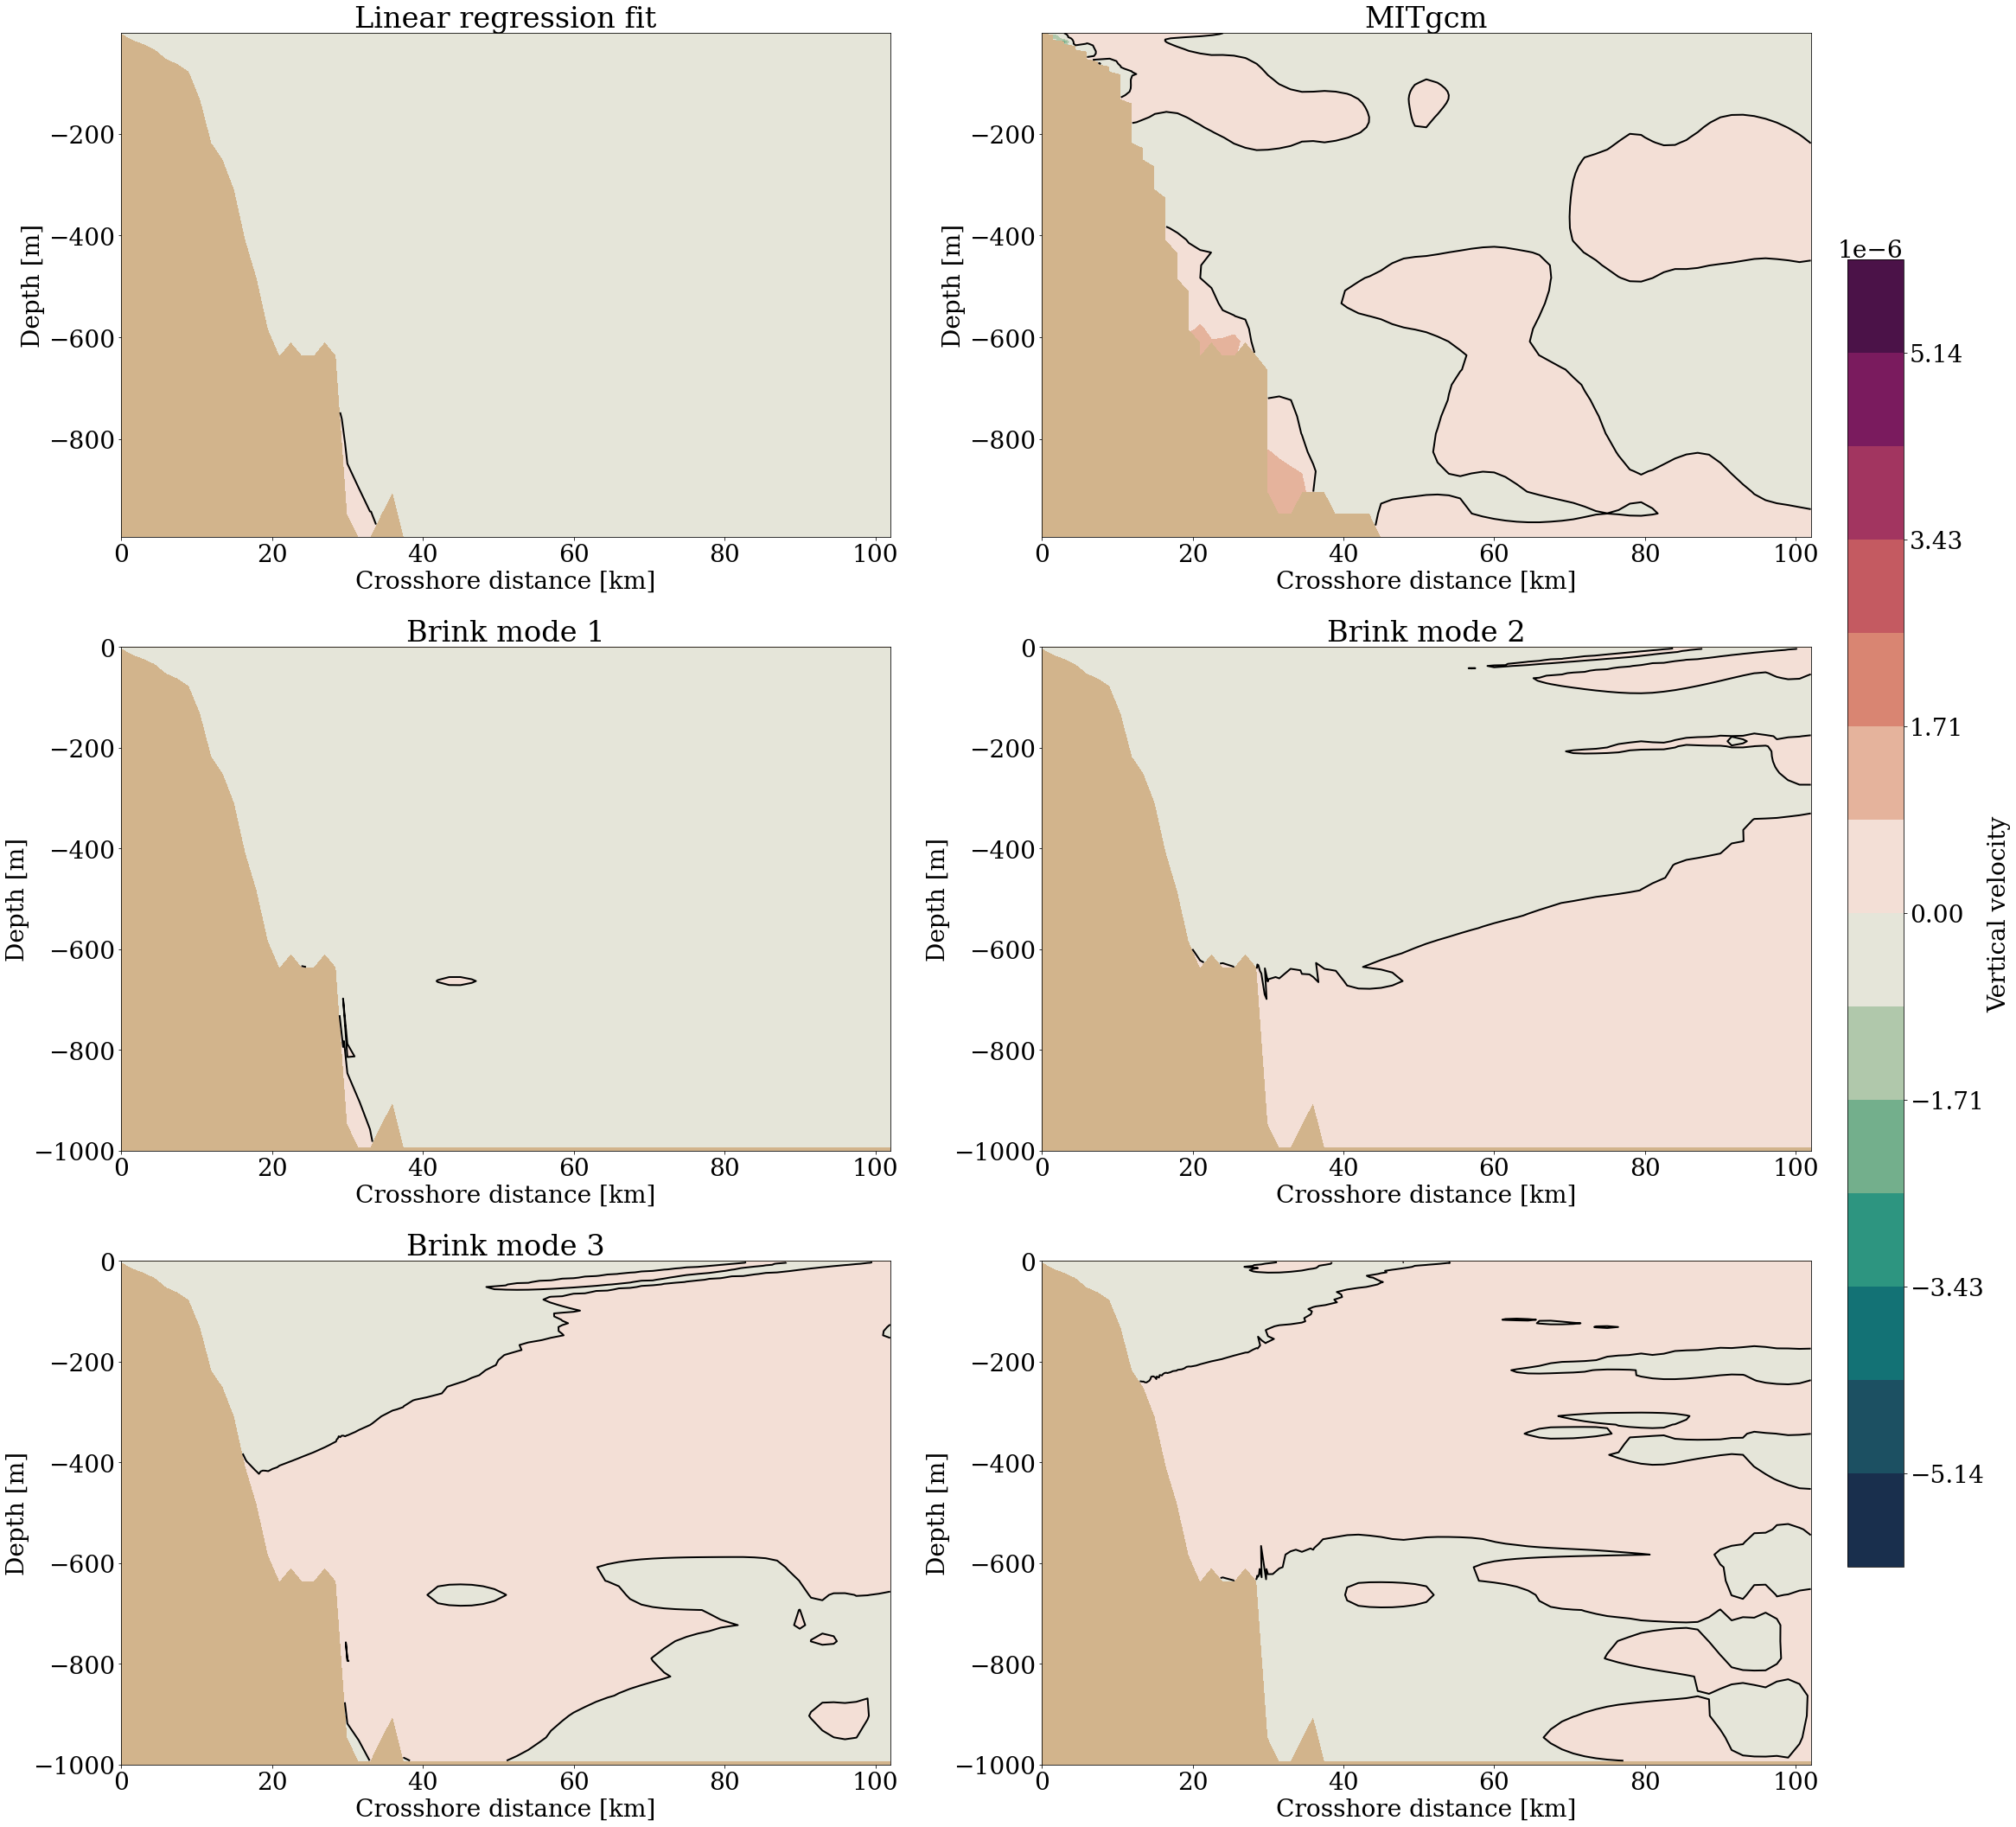

In [83]:
fig = plt.figure(figsize=(30, 30))
gs = GridSpec(nrows=3, ncols=2, height_ratios=[1,1,1])
xlab='Crosshore distance [km]'
ylab='Depth [m]'

vmin= -6e-6
vmax=6e-6
levels=np.linspace(vmin,vmax,15)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_facecolor('tan')
ax0.contourf(grid_X,grid_Z,VALfit[-1,:,:],cmap=cmocean.cm.curl,levels=levels)
ax0.contour(grid_X,grid_Z,VALfit[-1,:,:], levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax0.set(xlabel=xlab, ylabel=ylab)
ax0.set_title('Linear regression fit')


ax1 = fig.add_subplot(gs[0,1])
ax1.set_facecolor('tan')
ax1.contourf(dist,Z,np.ma.masked_array(VALmit,mask=VALmit==0),cmap=cmocean.cm.curl,levels=levels)
ax1.contour(dist, Z,np.ma.masked_array(VALmit,mask=VALmit==0), levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax1.set(xlabel=xlab, ylabel=ylab)
ax1.set_title('MITgcm')

ax2 = fig.add_subplot(gs[1, 0])
ax2.set_facecolor('tan')
ax2.contourf(grid_X,grid_Z,varbrink1,cmap=cmocean.cm.curl,levels=levels)
ax2.contour(grid_X,grid_Z,varbrink1, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax2.set(xlabel=xlab, ylabel=ylab)
ax2.set_title('Brink mode 1')
ax2.set_ylim([-1000,0])

ax3 = fig.add_subplot(gs[1, 1])
ax3.set_facecolor('tan')
ax3.contourf(grid_X,grid_Z,varbrink2,cmap=cmocean.cm.curl,levels=levels)
ax3.contour(grid_X,grid_Z,varbrink2, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax3.set(xlabel=xlab, ylabel=ylab)
ax3.set_title('Brink mode 2')
ax3.set_ylim([-1000,0])

ax4 = fig.add_subplot(gs[2, 0])
ax4.set_facecolor('tan')
ax4.contourf(grid_X,grid_Z,varbrink3,cmap=cmocean.cm.curl,levels=levels)
ax4.contour(grid_X,grid_Z,varbrink3, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax4.set(xlabel=xlab, ylabel=ylab)
ax4.set_title('Brink mode 3')
ax4.set_ylim([-1000,0])

ax5 = fig.add_subplot(gs[2, 1])
ax5.set_facecolor('tan')
cax2=ax5.contourf(grid_X,grid_Z,varbrink4,cmap=cmocean.cm.curl,levels=levels)
ax5.contour(grid_X,grid_Z,varbrink4, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax5.set(xlabel=xlab, ylabel=ylab)
ax5.set_ylim([-1000,0])

cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.7])
fig.colorbar(cax2, cax=cbar_ax)
cbar_ax.set_ylabel('Vertical velocity')
fig.tight_layout()
print(f'Regression line: Y = {betas[-1,0]:.2e} + {betas[-1,1]:.2e}X1+ {betas[-1,2]:.2e}X2 + {betas[-1,3]:.2e}X3+ {betas[-1,4]:.2e}X4')

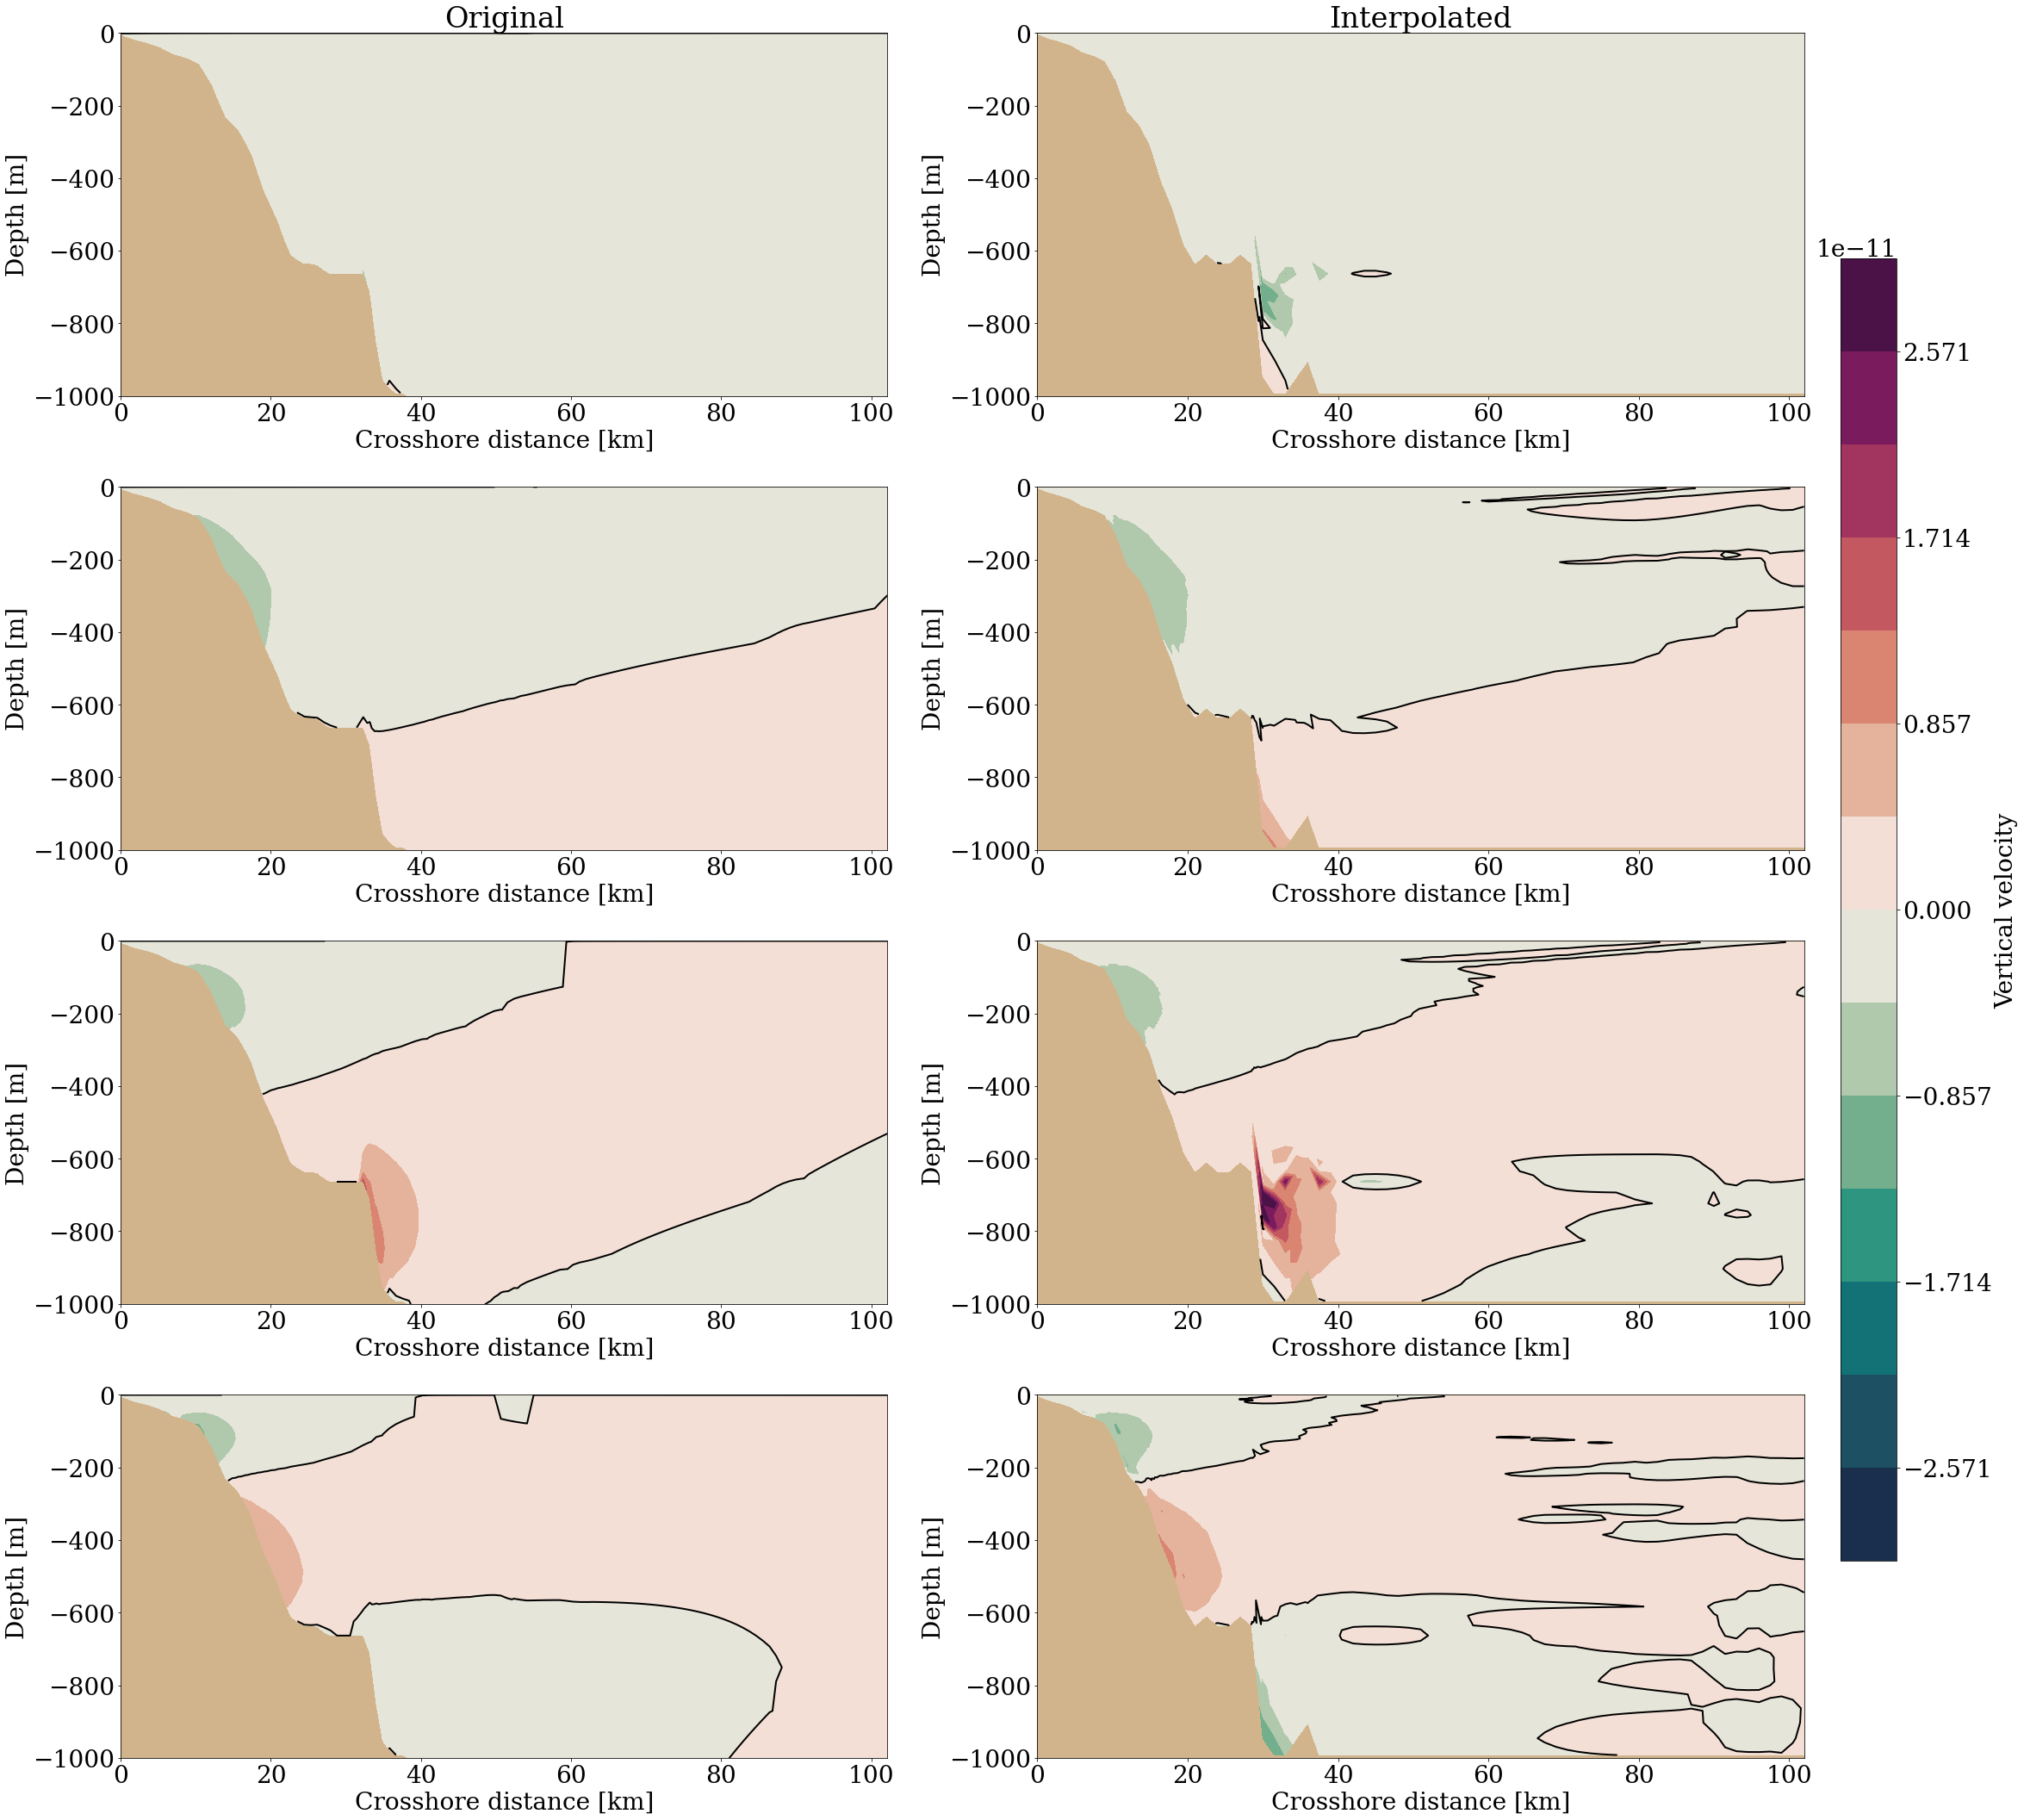

In [84]:
fig = plt.figure(figsize=(30, 30))
gs = GridSpec(nrows=4, ncols=2, height_ratios=[1, 1,1,1,])
xlab='Crosshore distance [km]'
ylab='Depth [m]'

vmin= -3e-11
vmax=3e-11
levels=np.linspace(vmin,vmax,15)

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor('tan')
ax0.contourf(xgr,zgr,w1.imag,cmap=cmocean.cm.curl,levels=levels)
ax0.contour(xgr, zgr,w1.imag, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax0.set(xlabel=xlab, ylabel=ylab)
ax0.set_title('Original')
ax0.set_ylim([-1000,0])


ax1 = fig.add_subplot(gs[0, 1])
ax1.set_facecolor('tan')
ax1.contourf(grid_X,grid_Z,varbrink1,cmap=cmocean.cm.curl,levels=levels)
ax1.contour(grid_X,grid_Z,varbrink1, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax1.set(xlabel=xlab, ylabel=ylab)
ax1.set_title('Interpolated')
ax1.set_ylim([-1000,0])

ax2 = fig.add_subplot(gs[1,0])
ax2.set_facecolor('tan')
ax2.contourf(xgr,zgr,w2.imag,cmap=cmocean.cm.curl,levels=levels)
ax2.contour(xgr, zgr,w2.imag, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax2.set(xlabel=xlab, ylabel=ylab)
ax2.set_ylim([-1000,0])

ax3 = fig.add_subplot(gs[1, 1])
ax3.set_facecolor('tan')
ax3.contourf(grid_X,grid_Z,varbrink2,cmap=cmocean.cm.curl,levels=levels)
ax3.contour(grid_X,grid_Z,varbrink2, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax3.set(xlabel=xlab, ylabel=ylab)
ax3.set_ylim([-1000,0])

ax4 = fig.add_subplot(gs[2, 0])
ax4.set_facecolor('tan')
ax4.contourf(xgr,zgr,w3.imag,cmap=cmocean.cm.curl,levels=levels)
ax4.contour(xgr, zgr,w3.imag, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax4.set(xlabel=xlab, ylabel=ylab)
ax4.set_ylim([-1000,0])
             
ax5 = fig.add_subplot(gs[2, 1])
ax5.set_facecolor('tan')
ax5.contourf(grid_X,grid_Z,varbrink3,cmap=cmocean.cm.curl,levels=levels)
ax5.contour(grid_X,grid_Z,varbrink3, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax5.set(xlabel=xlab, ylabel=ylab)
ax5.set_ylim([-1000,0])

ax6 = fig.add_subplot(gs[3, 0])
ax6.set_facecolor('tan')
ax6.contourf(xgr,zgr,w4.imag,cmap=cmocean.cm.curl,levels=levels)
ax6.contour(xgr, zgr,w4.imag, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax6.set(xlabel=xlab, ylabel=ylab)
ax6.set_ylim([-1000,0])
             

ax7 = fig.add_subplot(gs[3, 1])
ax7.set_facecolor('tan')
cax=ax7.contourf(grid_X,grid_Z,varbrink4,cmap=cmocean.cm.curl,levels=levels)
ax7.contour(grid_X,grid_Z,varbrink4, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax7.set(xlabel=xlab, ylabel=ylab)
ax7.set_ylim([-1000,0])

cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.7])
fig.colorbar(cax, cax=cbar_ax)
cbar_ax.set_ylabel('Vertical velocity')

fig.tight_layout()

# Alongshore velocity (v velocity)

Regression line: Y = -7.45e-06 + -8.59e+05X1+ 2.78e+05X2 + -5.86e+05X3+ 7.90e+05X4


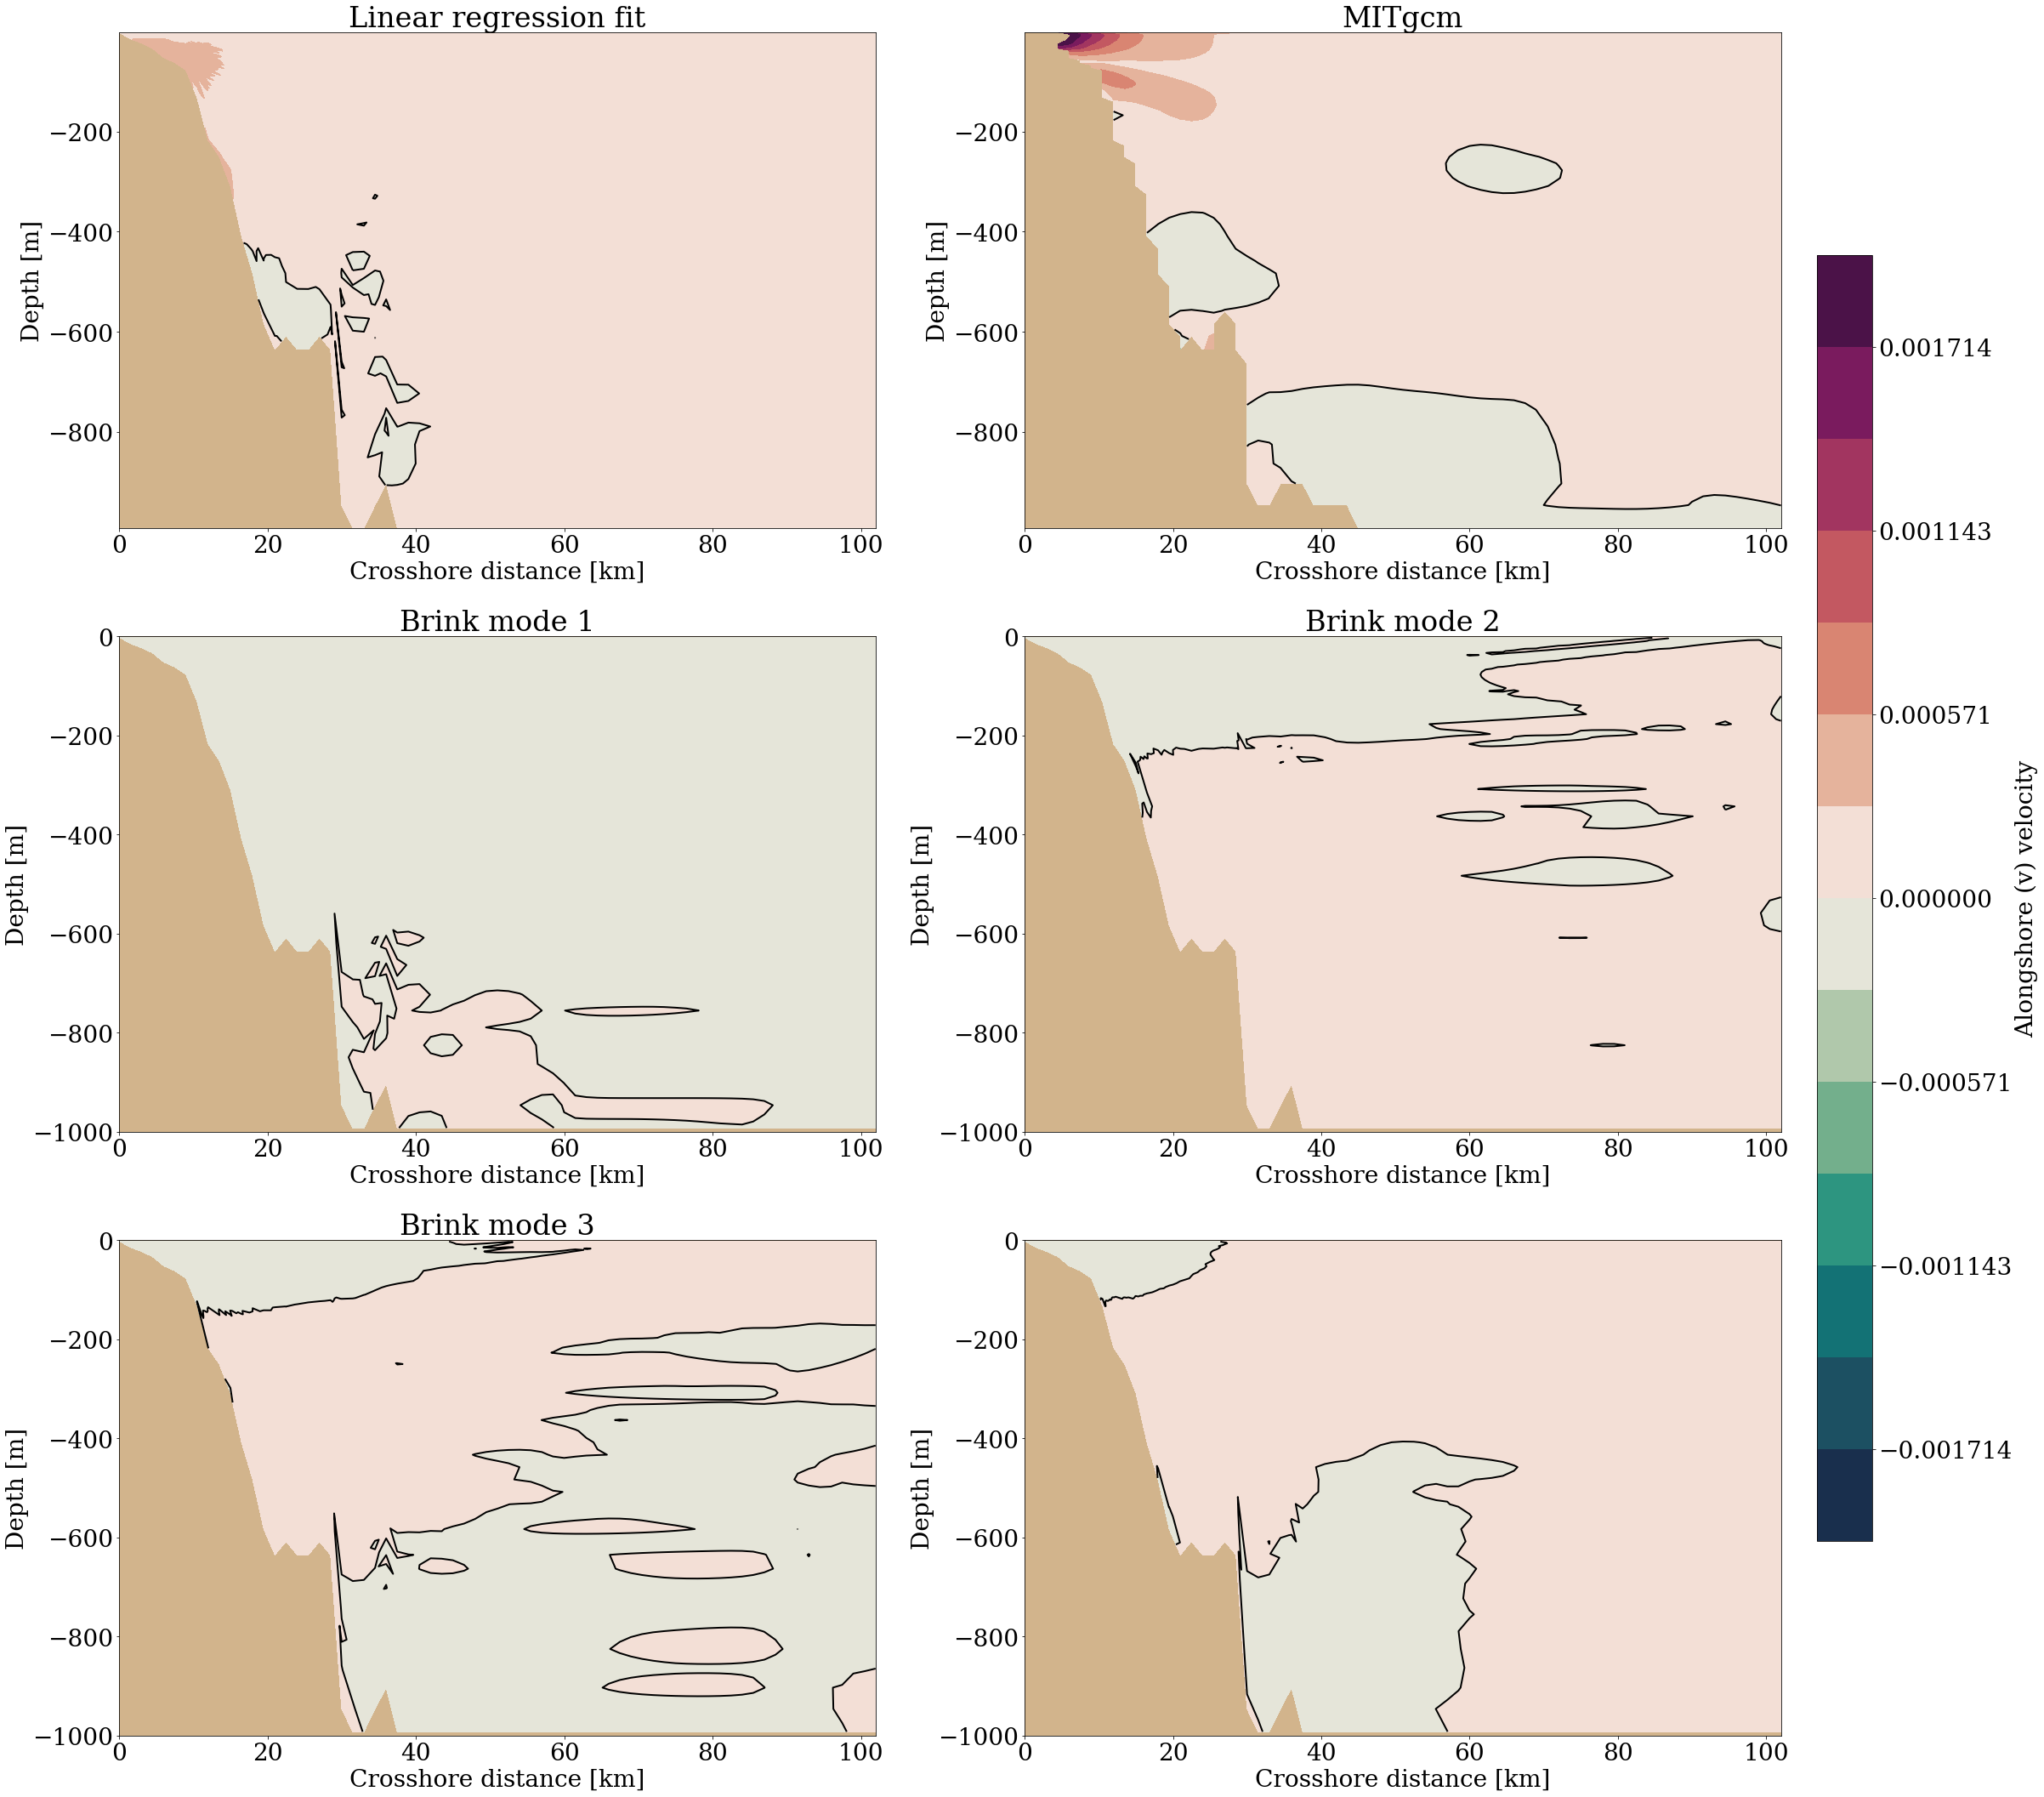

In [76]:
fig = plt.figure(figsize=(30, 30))
gs = GridSpec(nrows=3, ncols=2, height_ratios=[1,1,1])
xlab='Crosshore distance [km]'
ylab='Depth [m]'

vmin= -2e-3
vmax=2e-3
levels=np.linspace(vmin,vmax,15)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_facecolor('tan')
cax2=ax0.contourf(grid_X,grid_Z,VALfit[-1,:,:],cmap=cmocean.cm.curl,levels=levels)
ax0.contour(grid_X,grid_Z,VALfit[-1,:,:], levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax0.set(xlabel=xlab, ylabel=ylab)
ax0.set_title('Linear regression fit')


ax1 = fig.add_subplot(gs[0,1])
ax1.set_facecolor('tan')
ax1.contourf(dist,Z,np.ma.masked_array(VALmit,mask=VALmit==0),cmap=cmocean.cm.curl,levels=levels)
ax1.contour(dist, Z,np.ma.masked_array(VALmit,mask=VALmit==0), levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax1.set(xlabel=xlab, ylabel=ylab)
ax1.set_title('MITgcm')

ax2 = fig.add_subplot(gs[1, 0])
ax2.set_facecolor('tan')
ax2.contourf(grid_X,grid_Z,varbrink1,cmap=cmocean.cm.curl,levels=levels)
ax2.contour(grid_X,grid_Z,varbrink1, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax2.set(xlabel=xlab, ylabel=ylab)
ax2.set_title('Brink mode 1')
ax2.set_ylim([-1000,0])

ax3 = fig.add_subplot(gs[1, 1])
ax3.set_facecolor('tan')
ax3.contourf(grid_X,grid_Z,varbrink2,cmap=cmocean.cm.curl,levels=levels)
ax3.contour(grid_X,grid_Z,varbrink2, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax3.set(xlabel=xlab, ylabel=ylab)
ax3.set_title('Brink mode 2')
ax3.set_ylim([-1000,0])

ax4 = fig.add_subplot(gs[2, 0])
ax4.set_facecolor('tan')
ax4.contourf(grid_X,grid_Z,varbrink3,cmap=cmocean.cm.curl,levels=levels)
ax4.contour(grid_X,grid_Z,varbrink3, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax4.set(xlabel=xlab, ylabel=ylab)
ax4.set_title('Brink mode 3')
ax4.set_ylim([-1000,0])

ax5 = fig.add_subplot(gs[2, 1])
ax5.set_facecolor('tan')
ax5.contourf(grid_X,grid_Z,varbrink4,cmap=cmocean.cm.curl,levels=levels)
ax5.contour(grid_X,grid_Z,varbrink4, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax5.set(xlabel=xlab, ylabel=ylab)
ax5.set_ylim([-1000,0])

cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.7])
fig.colorbar(cax2, cax=cbar_ax)
cbar_ax.set_ylabel('Alongshore (v) velocity')
fig.tight_layout()
print(f'Regression line: Y = {betas[-1,0]:.2e} + {betas[-1,1]:.2e}X1+ {betas[-1,2]:.2e}X2 + {betas[-1,3]:.2e}X3+ {betas[-1,4]:.2e}X4')

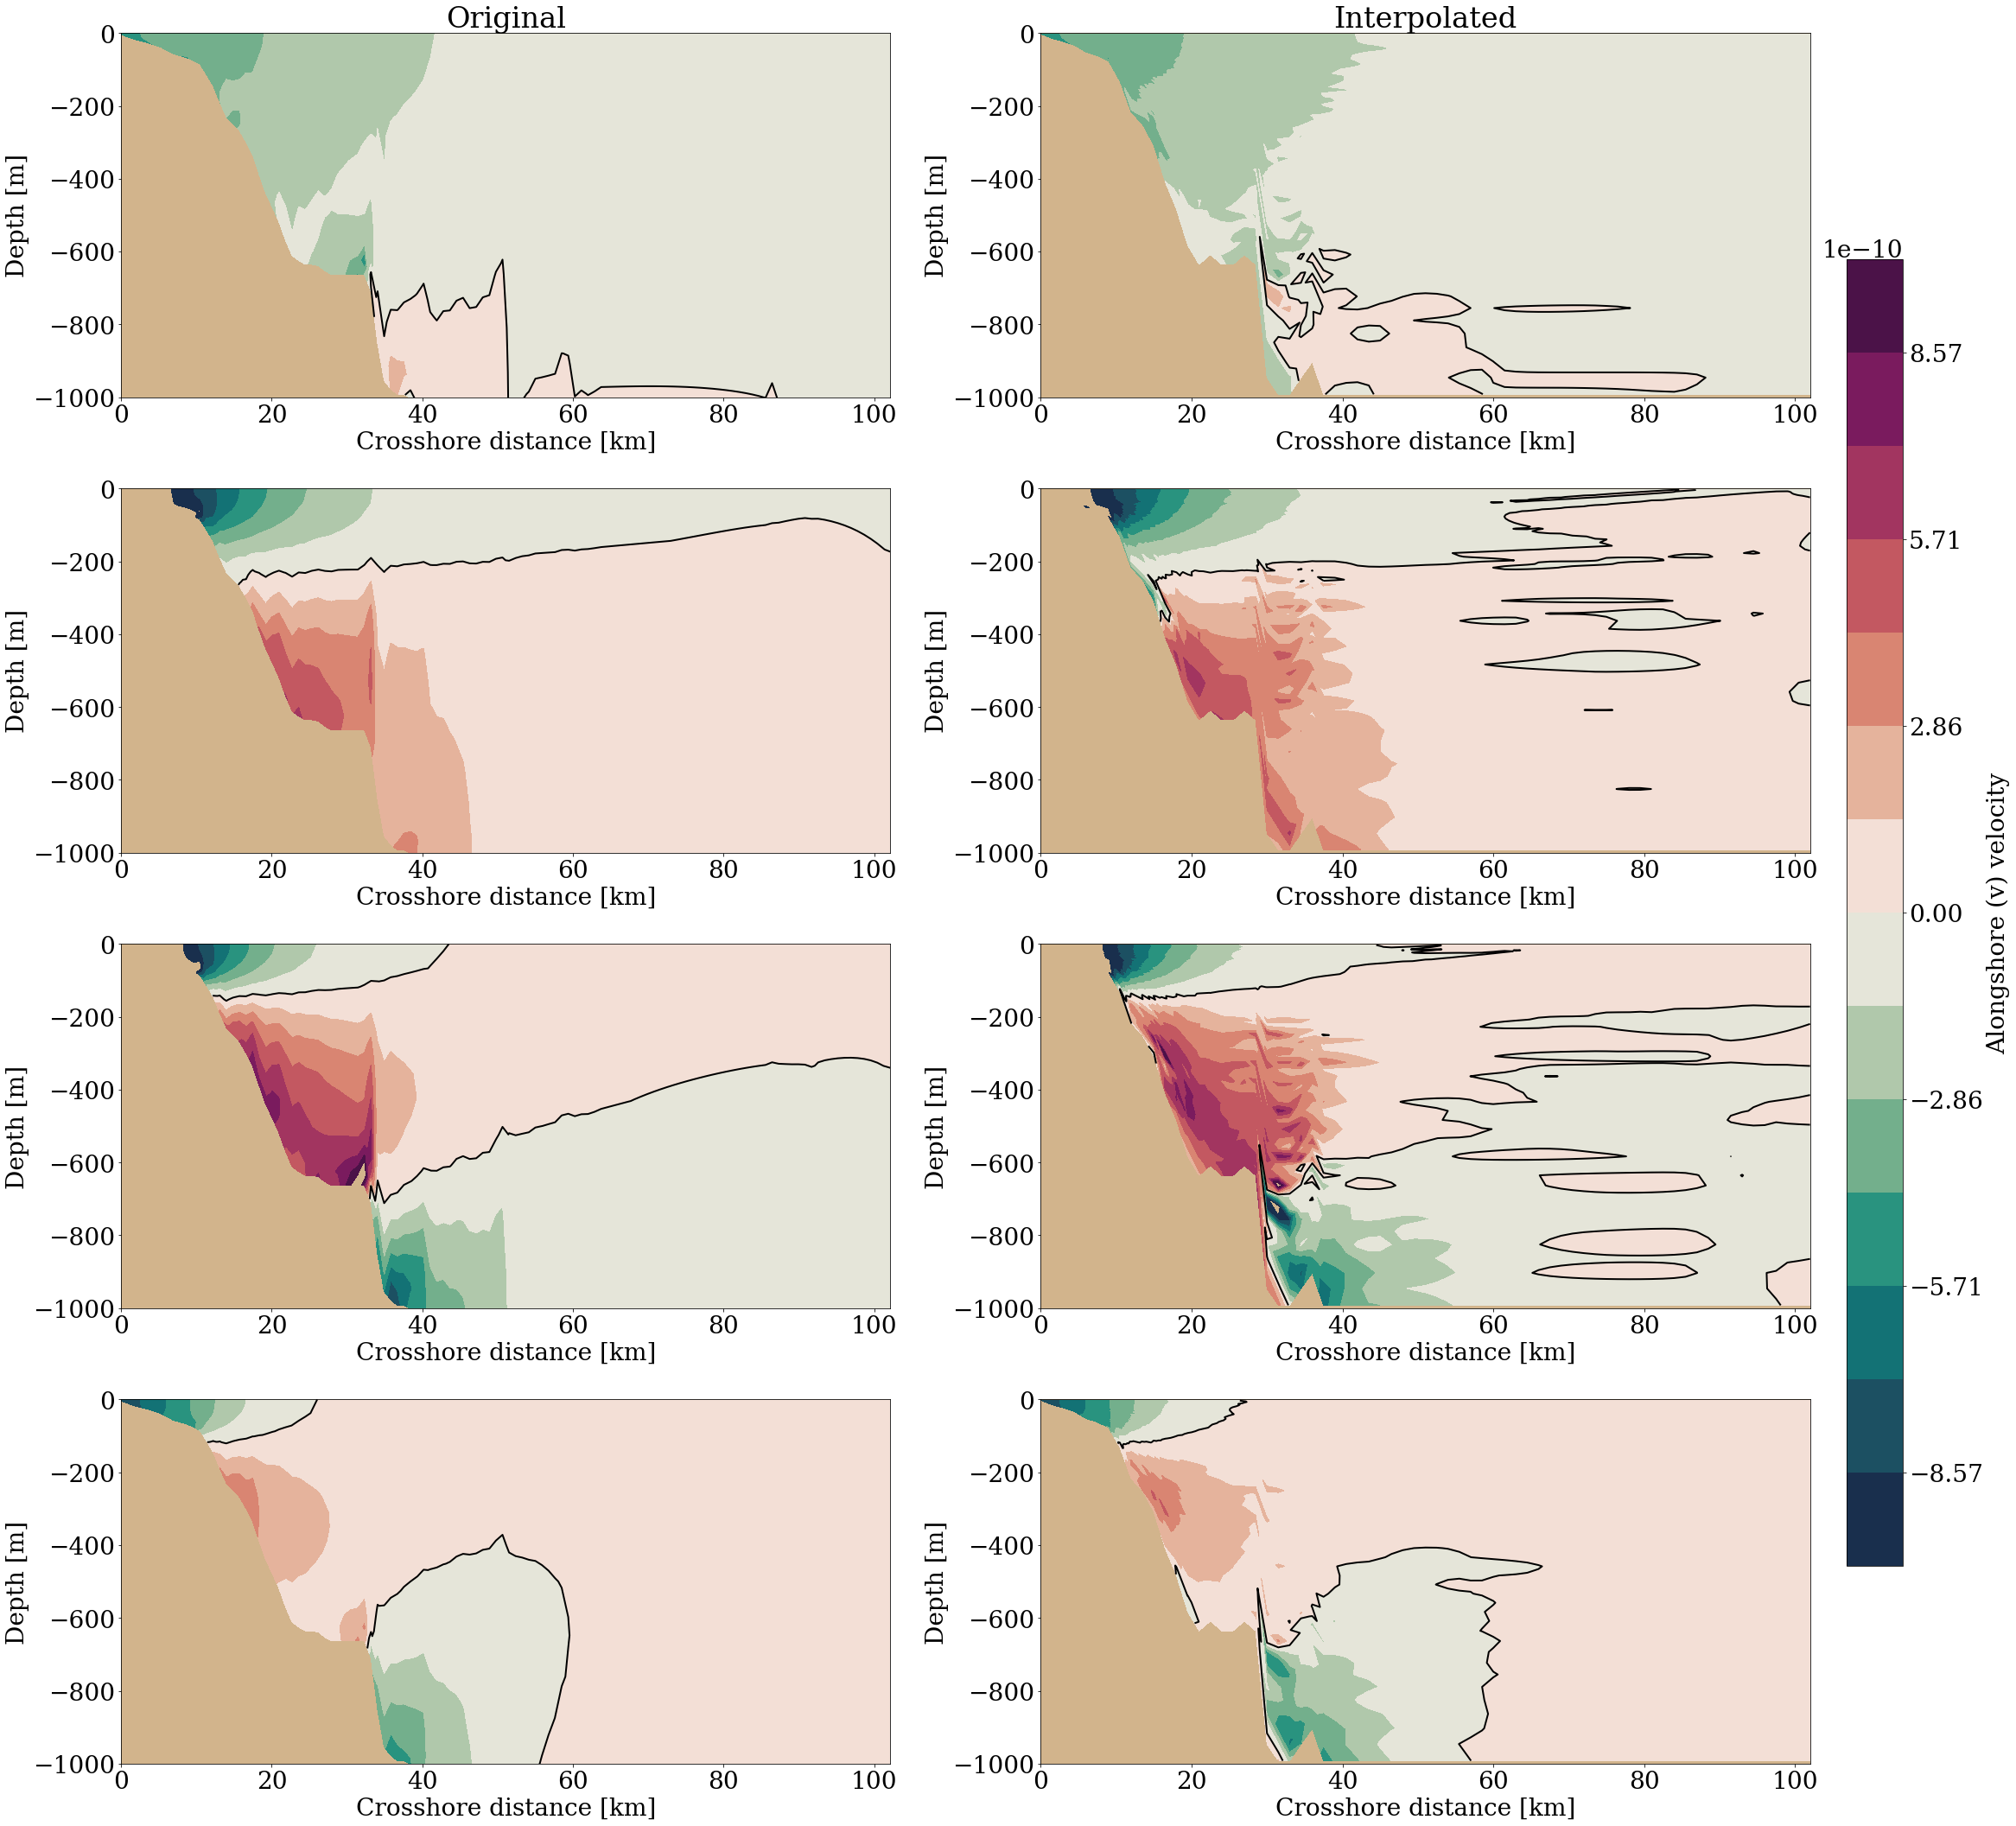

In [69]:
fig = plt.figure(figsize=(30, 30))
gs = GridSpec(nrows=4, ncols=2, height_ratios=[1, 1,1,1,])
xlab='Crosshore distance [km]'
ylab='Depth [m]'

vmin= -1e-9
vmax=1e-9
levels=np.linspace(vmin,vmax,15)

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor('tan')
ax0.contourf(xgr,zgr,v1,cmap=cmocean.cm.curl,levels=levels)
ax0.contour(xgr, zgr,v1, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax0.set(xlabel=xlab, ylabel=ylab)
ax0.set_title('Original')
ax0.set_ylim([-1000,0])


ax1 = fig.add_subplot(gs[0, 1])
ax1.set_facecolor('tan')
ax1.contourf(grid_X,grid_Z,varbrink1,cmap=cmocean.cm.curl,levels=levels)
ax1.contour(grid_X,grid_Z,varbrink1, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax1.set(xlabel=xlab, ylabel=ylab)
ax1.set_title('Interpolated')
ax1.set_ylim([-1000,0])

ax2 = fig.add_subplot(gs[1,0])
ax2.set_facecolor('tan')
ax2.contourf(xgr,zgr,v2,cmap=cmocean.cm.curl,levels=levels)
ax2.contour(xgr, zgr,v2, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax2.set(xlabel=xlab, ylabel=ylab)
ax2.set_ylim([-1000,0])

ax3 = fig.add_subplot(gs[1, 1])
ax3.set_facecolor('tan')
ax3.contourf(grid_X,grid_Z,varbrink2,cmap=cmocean.cm.curl,levels=levels)
ax3.contour(grid_X,grid_Z,varbrink2, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax3.set(xlabel=xlab, ylabel=ylab)
ax3.set_ylim([-1000,0])

ax4 = fig.add_subplot(gs[2, 0])
ax4.set_facecolor('tan')
ax4.contourf(xgr,zgr,v3,cmap=cmocean.cm.curl,levels=levels)
ax4.contour(xgr, zgr,v3, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax4.set(xlabel=xlab, ylabel=ylab)
ax4.set_ylim([-1000,0])
             
ax5 = fig.add_subplot(gs[2, 1])
ax5.set_facecolor('tan')
ax5.contourf(grid_X,grid_Z,varbrink3,cmap=cmocean.cm.curl,levels=levels)
ax5.contour(grid_X,grid_Z,varbrink3, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax5.set(xlabel=xlab, ylabel=ylab)
ax5.set_ylim([-1000,0])

ax6 = fig.add_subplot(gs[3, 0])
ax6.set_facecolor('tan')
ax6.contourf(xgr,zgr,v4,cmap=cmocean.cm.curl,levels=levels)
ax6.contour(xgr, zgr,v4, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax6.set(xlabel=xlab, ylabel=ylab)
ax6.set_ylim([-1000,0])
             

ax7 = fig.add_subplot(gs[3, 1])
ax7.set_facecolor('tan')
cax=ax7.contourf(grid_X,grid_Z,varbrink4,cmap=cmocean.cm.curl,levels=levels)
ax7.contour(grid_X,grid_Z,varbrink4, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax7.set(xlabel=xlab, ylabel=ylab)
ax7.set_ylim([-1000,0])

cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.7])
fig.colorbar(cax, cax=cbar_ax)
cbar_ax.set_ylabel('Alongshore (v) velocity')

fig.tight_layout()

Text(0, 0.5, 'Pressure')

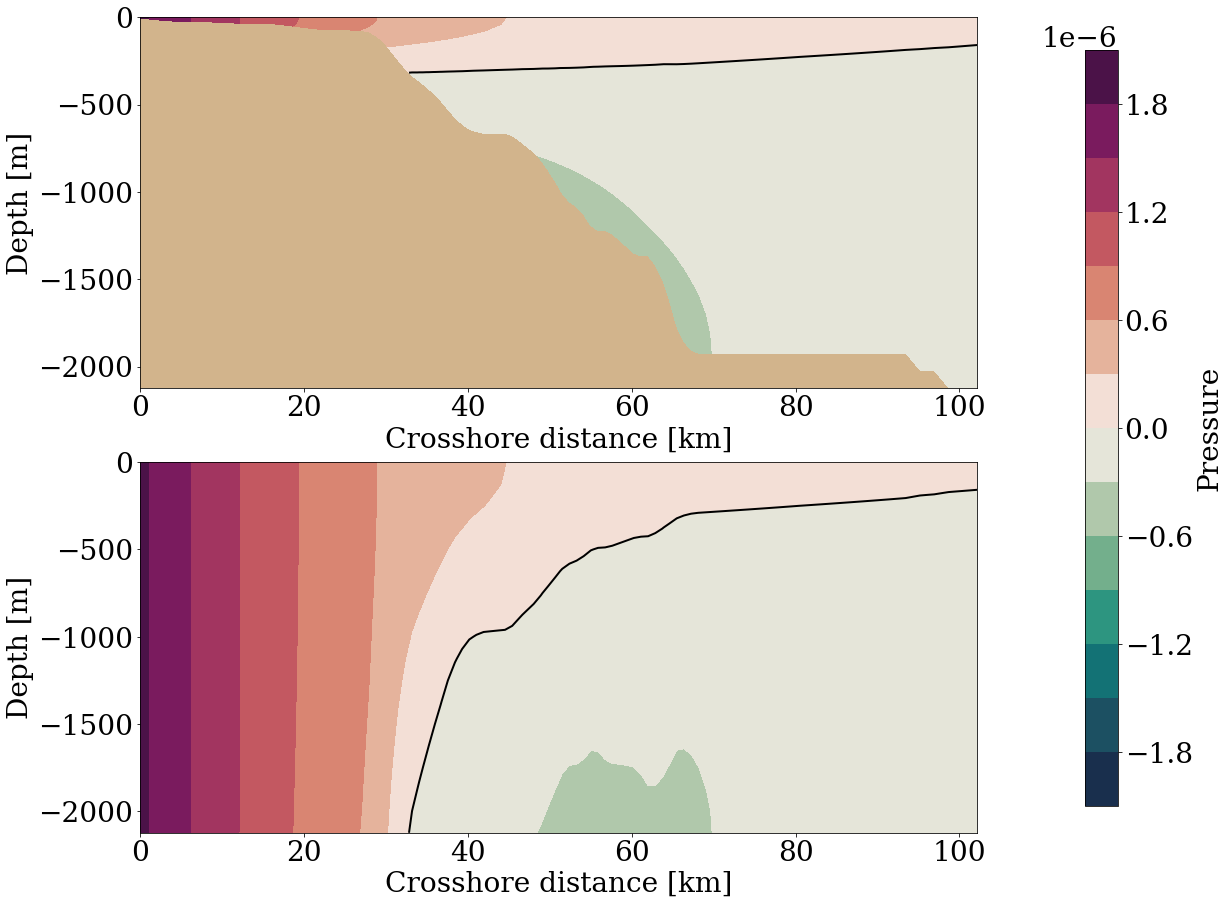

In [248]:
pbmin= -2.1e-6
pbmax=2.1e-6
levels=np.linspace(pbmin,pbmax,15)
xlab='Crosshore distance [km]'
ylab='Depth [m]'
fig,ax2 = plt.subplots(2)

ax2[0].set_facecolor('tan')
cax2=ax2[0].contourf(xgr,zgr,p1,cmap=cmocean.cm.curl,levels=levels)
ax2[0].contour(xgr,zgr,p1, levels=[0], linewidths=2, 
              linestyles='-', colors='k', zorder=2)
ax2[0].set(xlabel=xlab, ylabel=ylab)


ax2[1].set_facecolor('tan')
cax3=ax2[1].contourf(xpl,z,p1,cmap=cmocean.cm.curl,levels=levels)
ax2[1].contour(xpl,z,p1, levels=[0], linewidths=2, 
               linestyles='-', colors='k', zorder=2)
ax2[1].set(xlabel=xlab, ylabel=ylab)


cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.7])
fig.colorbar(cax2, cax=cbar_ax)
cbar_ax.set_ylabel('Pressure')


# LOOKING AT PRESSURE

## Removing a few values to make the matrices to get the same dimensions
I am not sure how to perform this, I have picked out 9 depth points in the MITgcm model that agree with the given points in the Brink model. I now need to get the vectors the same length in the x direction, I have 67 in MITgcm and 118 in the Brink data. I have below attempted to just take out an even distribution of the data, every 2nd data point for the brink data is removed while every tenth of the MITgcm is removed. They are now both 9 point in z and 60 in x.  

In [302]:
dist=np.flip(dist30)
varbrink,varmit=interpolate(VALmit,p,dist,xpl,Z,z)

## Ravel matrices into 1D vectors, using order C

In [466]:
x=np.ravel(varmit4,order='C') #Independent (observed input)
Y=np.ravel(varbrink4,order='C') #Dependent model parameter

In [189]:
Y=Y[np.where(x!=0)]
x=x[np.where(x!=0)]
x=x[np.where(Y!=0)]
Y=Y[np.where(Y!=0)]

## First way of performing linear regression
##### Linear model $Y = \beta_{0} +  \beta_{1}X $ where $\beta_{0}$ is the intercept  and $\beta_{1}$ is the slope of the linear equation  

#### Add a column of ones in the same size as the independent parameter to be able to perform matrix operations

In [305]:
X=np.vstack((np.ones(len(x)), x)).T

#### Calculating the beta values  $\hat{\beta} = (X^{T}.X)^{-1}.X^{T}.Y $

In [306]:
beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [307]:
beta_hat

array([-3.53919719e-07,  4.94271760e-01])

#### Calculating the dot product of the beta values with my predictor variable

In [308]:
yhat=X.dot(beta_hat)

## 2nd way of performing linear regression

$y_{i}=\hat{y_{i}} + \epsilon_{i}$ where $\hat{y_{i}}=b_{0}+b_{1}x_{i}$ $\epsilon$ is the error. 
We need to minimize the sum of squared errors (SSE, the variance not explained by the lin reg model).
$SSE=SST-SSR$ where $SST = \sum\limits_{i-1}^{N} (y_{i}-\bar{y})²$ (variance in the data) and $SSR = \sum\limits_{i-1}^{N} (\hat{y}_{i}-\bar{y})²$ (amount of the variance explained by our regression model

We want to find the partial derivaitves of $ SSE= \sum\limits_{i=1}^{N} [y_{i}-(b_{0}+b_{1}x_{i})]²$ with respects to both $b_{0}$ and $b_{1}$ setting the result to zero.

This gives: 
$\hat{b_{1}}=\frac{[N\sum_{i=1}^{N}x_{i}y_{i}-\sum_{i=1}^{N}x_{i}\sum_{i=1}^{N}y_{i}]}{[N\sum_{i=1}^{N}x_{i}^{2}-(\sum_{i=1}^{N}x_{i})^{2}]}$ and in turn
$\hat{b_{0}}=\bar{y}-\hat{b}_{1}\bar{x}$



For multivariate regression we instead get $y_{i}= b_{0}+b_{1}x_{i1}+b_{2}x_{i2}+...+b_{k}x_{ik}+ \epsilon_{i}$ and then writing this in matrix form with the x:s together as matrix $\mathbf{X}$ with k columns, $\mathbf{B}$ as a vector with k rows and $\mathbf{E}$ and $\mathbf{Y}$ as vectors with $\mathbf{N}$ (length of y and every x) amount of rows. 
The equation can then be expressed as $\mathbf{Y}=\mathbf{B} \cdot \mathbf{X} + \mathbf{E}$. Then the least squares equations can be expressed as: $\mathbf{B} = (\mathbf{X}'\cdot \mathbf{X})^{-1}\mathbf{X}' \cdot \mathbf{Y} $

In [467]:
b1=(len(x)*sum(x*Y)-sum(x)*sum(Y))/(len(x)*sum(x**2)-(sum(x))**2)

In [468]:
b0=np.mean(Y)-b1*np.mean(x)

In [469]:
print(b0,b1)

nan nan


In [312]:
yhat2=b0+b1*x

## Third way of performing linear regression using a sci kit learn function

In [ ]:
regression = LinearRegression()
linear_model = regression.fit(x[:,np.newaxis],Y)

In [471]:
print(linear_model.intercept_)
print(linear_model.coef_)

-3.5391971929358376e-07
[0.49427176]


## Plot of the values, with the line of regression

Regression line: Y = -3.54e-07 + 4.94e-01X


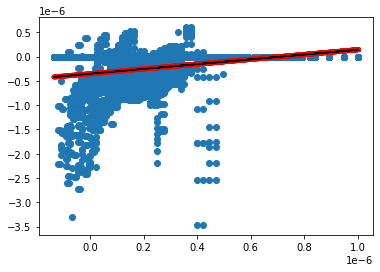

In [315]:
plt.scatter(x,Y)
plt.plot(x,yhat,'r',linewidth=5)
plt.plot(x,yhat2,'k')
print(f'Regression line: Y = {beta_hat[0]:.2e} + {beta_hat[1]:.2e}X')

# LOOKING AT VERTICAL VELOCITY

## Removing a few values to make the matrices to get the same dimensions
I am not sure how to perform this, I have picked out 9 depth points in the MITgcm model that agree with the given points in the Brink model. I now need to get the vectors the same length in the x direction, I have 67 in MITgcm and 118 in the Brink data. I have below attempted to just take out an even distribution of the data, every 2nd data point for the brink data is removed while every tenth of the MITgcm is removed. They are now both 9 point in z and 60 in x.  

## Ravel matrices into 1D vectors, using order C

In [320]:
x=np.ravel(varbrink,order='C') #Independent (observed input)
Y=np.ravel(varmit,order='C') #Dependent model parameter

In [239]:
Y=Y[np.where(x!=0)]
x=x[np.where(x!=0)]
x=x[np.where(Y!=0)]
Y=Y[np.where(Y!=0)]

## First way of performing linear regression
##### Linear model $Y = \beta_{0} +  \beta_{1}X $ where $\beta_{0}$ is the intercept  and $\beta_{1}$ is the slope of the linear equation  

#### Add a column of ones in the same size as the independent parameter to be able to perform matrix operations

In [321]:
X=np.vstack((np.ones(len(x)), x)).T

#### Calculating the beta values  $\hat{\beta} = (X^{T}.X)^{-1}.X^{T}.Y $

In [322]:
beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [323]:
beta_hat

array([2.54548283e-07, 1.65283238e-01])

#### Calculating the dot product of the beta values with my predictor variable

In [324]:
yhat=X.dot(beta_hat)

## 2nd way of performing linear regression

$y_{i}=\hat{y_{i}} + \epsilon_{i}$ where $\hat{y_{i}}=b_{0}+b_{1}x_{i}$ $\epsilon$ is the error. 
We need to minimize the sum of squared errors (SSE, the variance not explained by the lin reg model).
$SSE=SST-SSR$ where $SST = \sum\limits_{i-1}^{N} (y_{i}-\bar{y})²$ (variance in the data) and $SSR = \sum\limits_{i-1}^{N} (\hat{y}_{i}-\bar{y})²$ (amount of the variance explained by our regression model

We want to find the partial derivaitves of $ SSE= \sum\limits_{i=1}^{N} [y_{i}-(b_{0}+b_{1}x_{i})]²$ with respects to both $b_{0}$ and $b_{1}$ setting the result to zero.

This gives: 
$\hat{b_{1}}=\frac{[N\sum_{i=1}^{N}x_{i}y_{i}-\sum_{i=1}^{N}x_{i}\sum_{i=1}^{N}y_{i}]}{[N\sum_{i=1}^{N}x_{i}^{2}-(\sum_{i=1}^{N}x_{i})^{2}]}$ and in turn
$\hat{b_{0}}=\bar{y}-\hat{b}_{1}\bar{x}$



In [244]:
b1=(len(x)*sum(x*Y)-sum(x)*sum(Y))/(len(x)*sum(x**2)-(sum(x))**2)

In [245]:
b0=np.mean(Y)-b1*np.mean(x)

In [246]:
print(b0,b1)

1.6882334633587785e-07 0.006804384763936645


In [247]:
yhat2=b0+b1*x

## Third way of performing linear regression using a sci kit learn function

In [248]:
regression = LinearRegression()
linear_model = regression.fit(x[:,np.newaxis],Y)

In [249]:
print(linear_model.intercept_)
print(linear_model.coef_)

1.6882334633587746e-07
[0.00680438]


## Plot of the values, with the line of regression

Regression line: Y = 1.69e-07 + 6.80e-03X


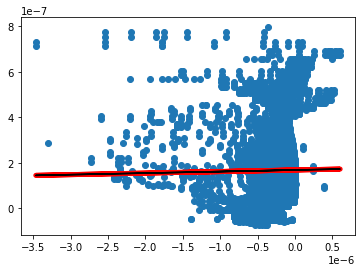

In [250]:
plt.scatter(x,Y)
plt.plot(x,yhat,'r',linewidth=5)
plt.plot(x,yhat2,'k')
print(f'Regression line: Y = {beta_hat[0]:.2e} + {beta_hat[1]:.2e}X')